In [2]:
# Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

# Install BioPython if not already installed
!pip install biopython

# Set the base directory for the files
base_dir = 'drive/My Drive/COMP0082/'

# Define file paths
file_paths = {
    'cyto': os.path.join(base_dir, 'cyto.fasta.txt'),
    'mito': os.path.join(base_dir, 'mito.fasta.txt'),
    'nuclear': os.path.join(base_dir, 'nuclear.fasta.txt'),
    'secreted': os.path.join(base_dir, 'secreted.fasta.txt'),
    'other': os.path.join(base_dir, 'other.fasta.txt'),
    'blind': os.path.join(base_dir, 'blind.fasta.txt')
}

# Check if all files exist
for location, path in file_paths.items():
    print(f"{location}: {'Exists' if os.path.exists(path) else 'NOT FOUND'}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cyto: Exists
mito: Exists
nuclear: Exists
secreted: Exists
other: Exists
blind: Exists


In [3]:
# Import necessary libraries
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter

In [4]:
# Function to read FASTA files and create a DataFrame
def read_fasta_to_df(file_path, label=None):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        seq_data = {
            'id': record.id,
            'sequence': str(record.seq),
            'length': len(record.seq)
        }
        if label:
            seq_data['label'] = label
        sequences.append(seq_data)
    return pd.DataFrame(sequences)

# Load all the data
data = {}
for location, path in file_paths.items():
    if location != 'blind':  # For the training/validation data
        data[location] = read_fasta_to_df(path, location)
    else:  # For the blind test set
        data[location] = read_fasta_to_df(path)

# Combine all training data
train_data = pd.concat([data['cyto'], data['mito'], data['nuclear'], data['secreted'], data['other']])

# Print some basic statistics
print("\nDataset statistics:")
print(f"Total training sequences: {len(train_data)}")
for location in ['cyto', 'mito', 'nuclear', 'secreted', 'other']:
    print(f"{location}: {len(data[location])} sequences")
print(f"Blind test set: {len(data['blind'])} sequences")

# Display a few examples from each class
print("\nSample sequences:")
for location in ['cyto', 'mito', 'nuclear', 'secreted', 'other']:
    print(f"\n{location.upper()} example:")
    sample = data[location].iloc[0]
    print(f"ID: {sample['id']}")
    print(f"Sequence (first 50 aa): {sample['sequence'][:50]}...")
    print(f"Length: {sample['length']}")


Dataset statistics:
Total training sequences: 9460
cyto: 2463 sequences
mito: 1023 sequences
nuclear: 2736 sequences
secreted: 1236 sequences
other: 2002 sequences
Blind test set: 20 sequences

Sample sequences:

CYTO example:
ID: sp|P0C0T2|ANKS6_RAT
Sequence (first 50 aa): MGEGALAPGLQLLLRACEQGDTDTARRLLEPGGEPVAGSEAGAEPAGPEA...
Length: 885

MITO example:
ID: sp|P36112|MIC60_YEAST
Sequence (first 50 aa): MMLRTTASRKIVLRRGLASINTGTTVASKKASHKFRNTLWTIALSATAFY...
Length: 540

NUCLEAR example:
ID: sp|Q8W4L5|VAL1_ARATH
Sequence (first 50 aa): MFEVKMGSKMCMNASCGTTSTVEWKKGWPLRSGLLADLCYRCGSAYESSL...
Length: 790

SECRETED example:
ID: sp|P0CJ36|EUMER_EUMRB
Sequence (first 50 aa): LNLKGLIKKVASLLN...
Length: 15

OTHER example:
ID: Q1BCC9
Sequence (first 50 aa): MGVAGAPAGERIEVEPDALIGAGKQMGSLGTQLGMLSDALGSVVSAGLAS...
Length: 1551



Class Distribution:
nuclear: 2736 sequences (28.92%)
cyto: 2463 sequences (26.04%)
other: 2002 sequences (21.16%)
secreted: 1236 sequences (13.07%)
mito: 1023 sequences (10.81%)


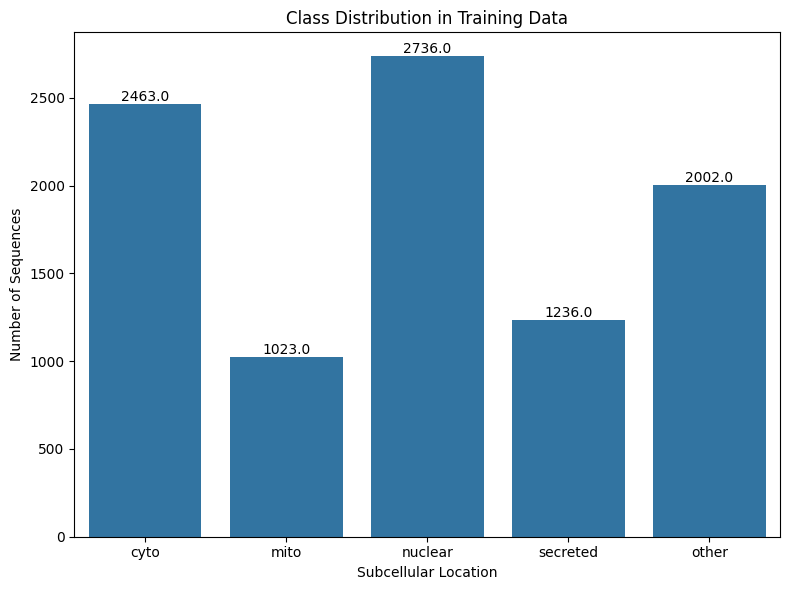

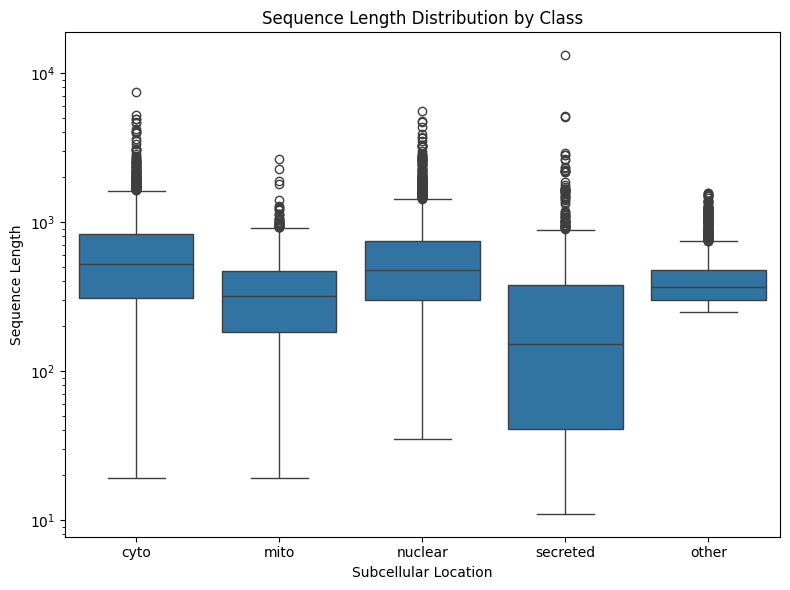

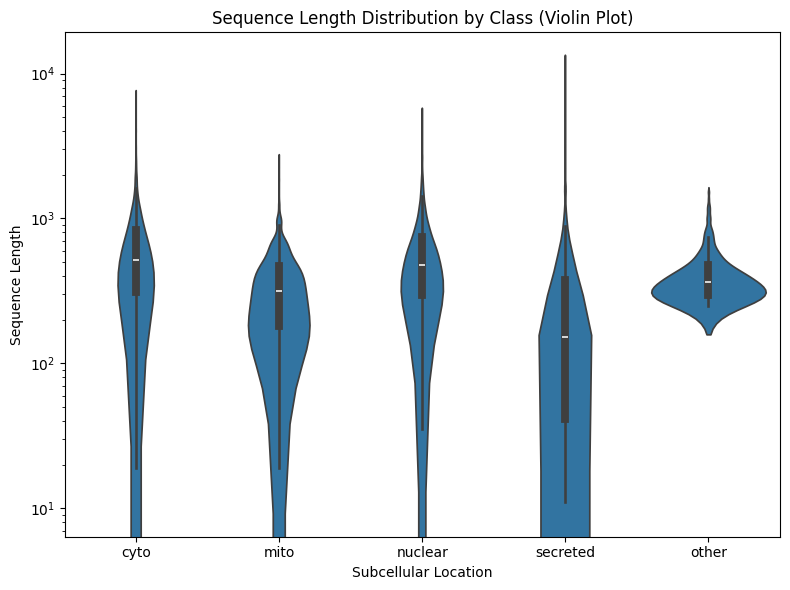


Sequence Length Statistics by Class:
           count        mean         std    min     25%    50%    75%      max
label                                                                         
cyto      2463.0  654.889160  547.626170   19.0  309.00  518.0  832.0   7393.0
mito      1023.0  362.558162  250.722101   19.0  181.00  316.0  470.5   2628.0
nuclear   2736.0  606.588450  491.198879   35.0  297.00  478.0  747.5   5560.0
other     2002.0  430.595904  206.747544  249.0  297.25  365.0  475.5   1551.0
secreted  1236.0  298.160194  556.739624   11.0   41.00  152.0  378.5  13100.0

Imbalance Ratio (max class size / min class size): 2.67

Number of outlier sequences (by length): 621
Percentage of outliers: 6.56%

Outliers by class:
cyto: 276 outliers (11.21% of class)
nuclear: 263 outliers (9.61% of class)
secreted: 41 outliers (3.32% of class)
other: 31 outliers (1.55% of class)
mito: 10 outliers (0.98% of class)


In [5]:
# Analyze class distribution
class_counts = train_data['label'].value_counts()
print("\nClass Distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count} sequences ({count/len(train_data)*100:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=train_data)
plt.title('Class Distribution in Training Data')
plt.xlabel('Subcellular Location')
plt.ylabel('Number of Sequences')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Analyze sequence length distribution across classes
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='length', data=train_data)
plt.title('Sequence Length Distribution by Class')
plt.xlabel('Subcellular Location')
plt.ylabel('Sequence Length')
plt.yscale('log')  # Using log scale for better visualization if lengths vary greatly
plt.tight_layout()
plt.show()

# Create a violin plot for a more detailed view of distribution
plt.figure(figsize=(8, 6))
sns.violinplot(x='label', y='length', data=train_data)
plt.title('Sequence Length Distribution by Class (Violin Plot)')
plt.xlabel('Subcellular Location')
plt.ylabel('Sequence Length')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Calculate summary statistics for sequence lengths by class
length_stats = train_data.groupby('label')['length'].describe()
print("\nSequence Length Statistics by Class:")
print(length_stats)

# Let's also calculate the Imbalance Ratio (IR) = max_class_size / min_class_size
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance Ratio (max class size / min class size): {imbalance_ratio:.2f}")

# Identify extremely long or short sequences
q1 = train_data['length'].quantile(0.25)
q3 = train_data['length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = train_data[(train_data['length'] < lower_bound) | (train_data['length'] > upper_bound)]
print(f"\nNumber of outlier sequences (by length): {len(outliers)}")
print(f"Percentage of outliers: {len(outliers) / len(train_data) * 100:.2f}%")

# Count outliers by class
outliers_by_class = outliers['label'].value_counts()
print("\nOutliers by class:")
for label, count in outliers_by_class.items():
    class_total = class_counts[label]
    print(f"{label}: {count} outliers ({count/class_total*100:.2f}% of class)")

Here's an analysis of the sequence length statistics:

### Class Distribution and Imbalance
- The imbalance ratio of 2.67 indicates a moderate class imbalance, with Nuclear proteins being the largest class (2736 sequences) and Mitochondrial proteins the smallest (1023 sequences).
- This level of imbalance isn't extreme but should be addressed during model training (e.g., through class weighting or sampling techniques).

### Sequence Length Patterns by Class
1. **Cytosolic proteins** (mean: 654.9, median: 518)
   - Longest average sequence length
   - High variability (standard deviation: 547.6)
   - Many outliers (11.21% of class)
   - Biologically makes sense as cytosolic proteins perform diverse functions needing varied structures

2. **Nuclear proteins** (mean: 606.6, median: 478)
   - Second longest on average
   - High variability (standard deviation: 491.2)
   - Many outliers (9.61% of class)
   - Consistent with nuclear proteins often having complex DNA/RNA binding domains

3. **Other proteins** (prokaryotic contaminants) (mean: 430.6, median: 365)
   - Most consistent length distribution (smallest standard deviation: 206.7)
   - Notably higher minimum length (249) than eukaryotic proteins
   - Few outliers (1.55%)
   - This consistency is typical of prokaryotic proteins

4. **Mitochondrial proteins** (mean: 362.6, median: 316)
   - Moderate length with smaller variation
   - Very few outliers (0.98%)
   - This suggests more conserved structural constraints

5. **Secreted proteins** (mean: 298.2, median: 152)
   - Shortest median length but extremely wide range (11-13100)
   - Highly right-skewed distribution (mean much higher than median)
   - This makes biological sense: secreted proteins often have cleaved signal peptides (shorter) but some extracellular matrix proteins can be very long

### Outliers
- 621 sequences (6.56% of total) are outliers based on length
- Mostly concentrated in cytosolic and nuclear classes
- These represent biologically meaningful variation rather than errors, as some proteins naturally have extreme lengths

### Implications for the Model
1. **Sequence length will be an informative feature** - the distinct length profiles between classes suggest this alone could provide signal
2. **Class imbalance should be addressed** - consider weighted loss functions or sampling techniques
3. **Handling outliers** - rather than removing them, normalize features to reduce extreme value impacts
4. **Cross-validation** - ensure the validation strategy accounts for class imbalance

These patterns align with biological understanding of protein subcellular localization and provide a good basis for feature engineering.

---

## Violin Plot: Analysis of Sequence Length Distribution Across Protein Classes

This violin plot reveals important biological patterns in protein length across subcellular locations:

## Key Observations by Class:

1. **Secreted Proteins**:
   - Most distinctive distribution - strongly bimodal
   - Contains both very short proteins (~10-50 aa) and much longer ones
   - Widest overall range (from ~10 to >10,000 aa)
   - Biological explanation: Short signal peptides and hormones vs. large extracellular matrix proteins like collagen

2. **Cytosolic Proteins**:
   - Broad distribution with positive skew
   - Median around 400-500 aa
   - Many outliers extending to several thousand amino acids
   - Biological explanation: Diverse functional requirements from small metabolic enzymes to large structural proteins

3. **Nuclear Proteins**:
   - Similar pattern to cytosolic proteins
   - Substantial overlap with cytosolic distribution
   - Biological explanation: This overlap partly explains the classification challenges between nuclear and cytosolic proteins

4. **Mitochondrial Proteins**:
   - Generally shorter than nuclear/cytosolic proteins
   - More concentrated distribution with fewer extreme outliers
   - Biological explanation: Size constraints of mitochondrial import machinery

5. **Other (Prokaryotic) Proteins**:
   - Most uniform distribution with least variance
   - Narrower range centered around 300-400 aa
   - Fewer extreme values
   - Biological explanation: Different evolutionary constraints and simpler cellular organization

## Implications for the Model:

1. **Length is informative but insufficient alone**: The substantial overlap between classes (especially nuclear and cytosolic) explains why length alone isn't enough for accurate classification

2. **Secreted protein advantage**: The distinctive bimodal distribution of secreted proteins helps explain why our model performed particularly well on this class after enhancements

3. **Multi-feature necessity**: The overlap in distributions reinforces why combining length with composition and targeting signal features was necessary for effective classification

4. **Biological validity**: These distributions align with our understanding of protein biology and support that the model is capturing genuine biological patterns

This visualization provides strong support for including sequence length as a feature while highlighting why additional signal-specific features were needed to achieve good classification performance.

Extracting amino acid compositions and biophysical properties...


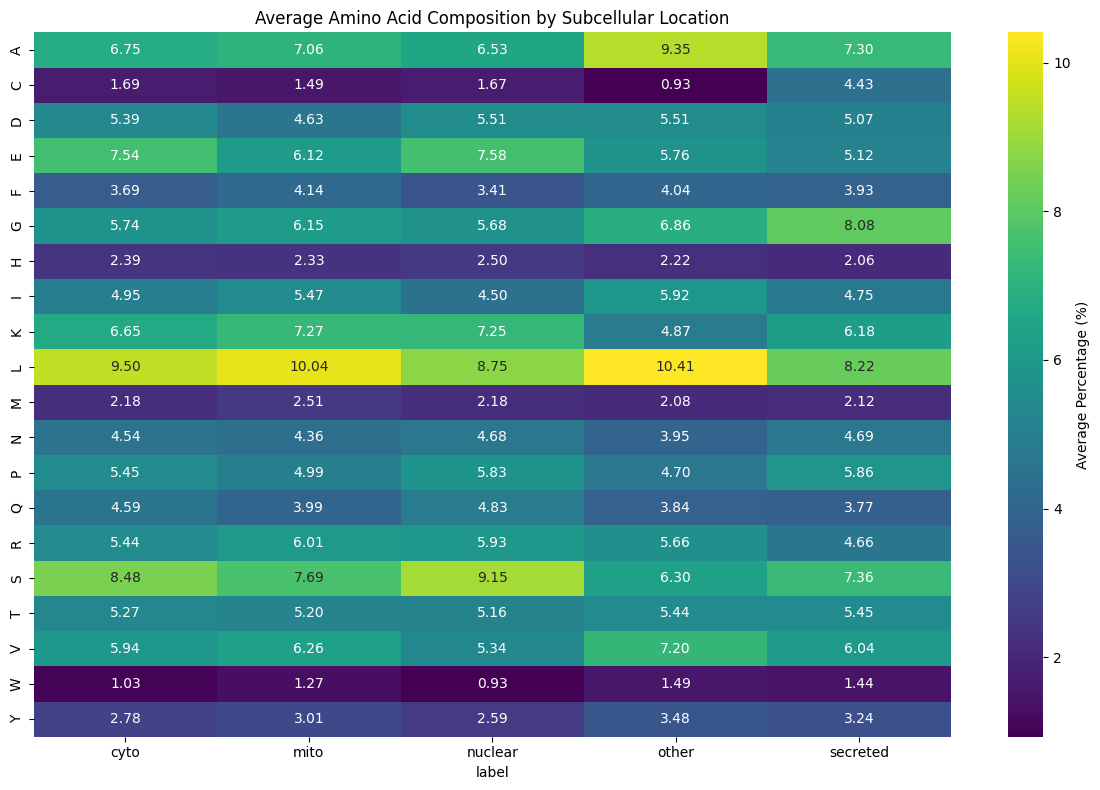

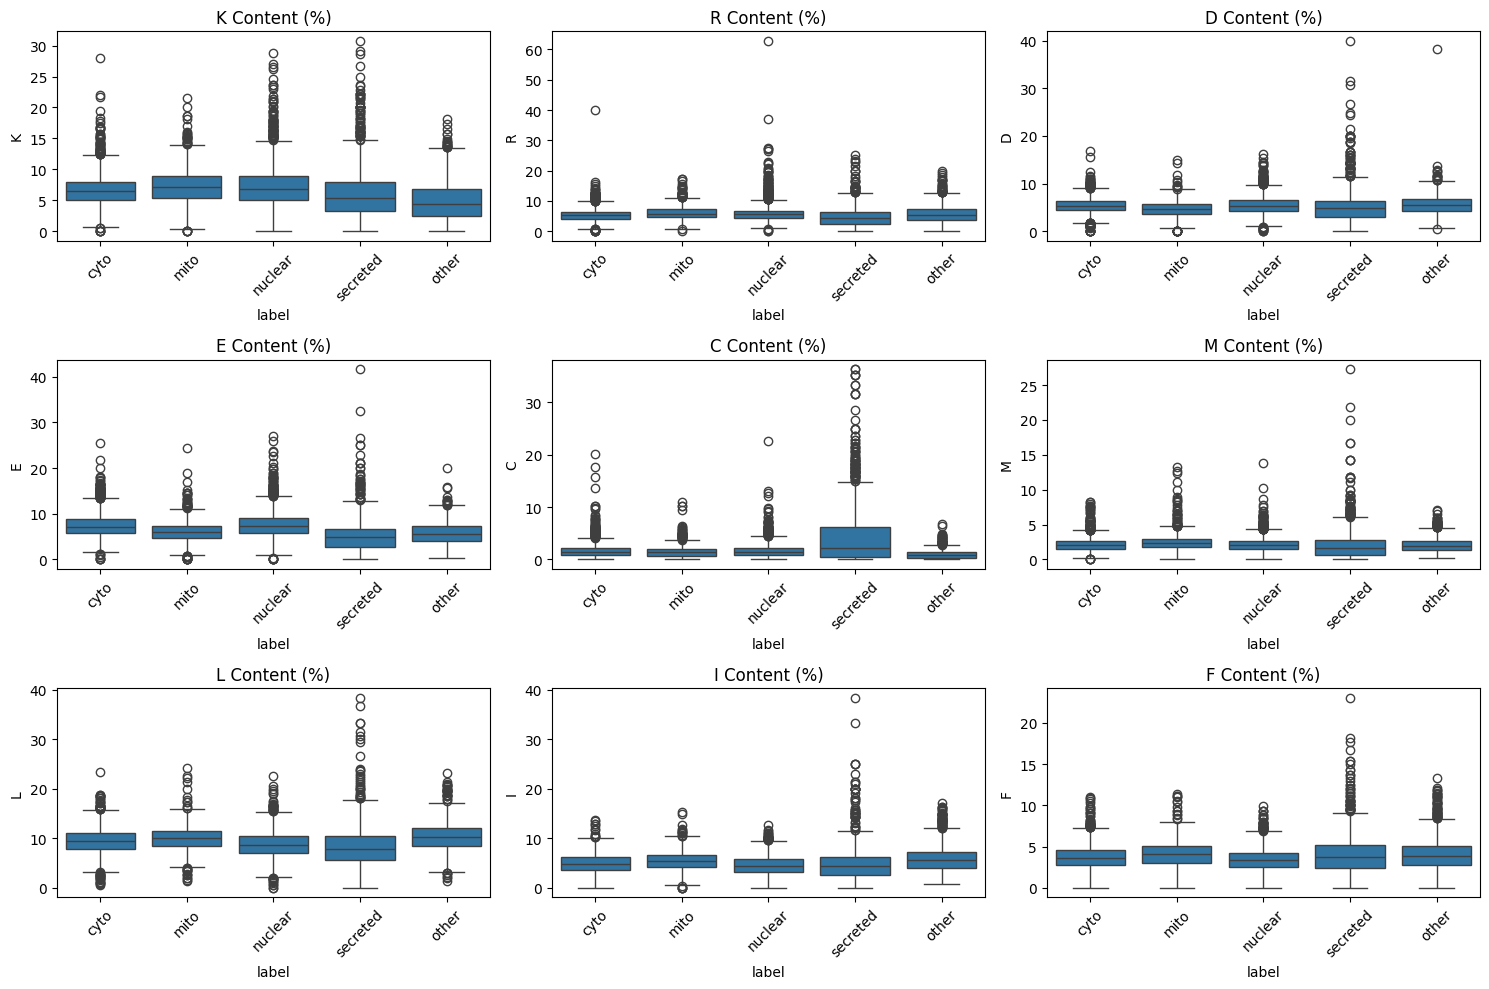


Amino acids with statistical differences between classes:
C: p-value = 0.000000 ***
S: p-value = 0.000000 ***
E: p-value = 0.000000 ***
A: p-value = 0.000000 ***
V: p-value = 0.000000 ***
K: p-value = 0.000000 ***
G: p-value = 0.000000 ***
L: p-value = 0.000000 ***
I: p-value = 0.000000 ***
W: p-value = 0.000000 ***
Y: p-value = 0.000000 ***
Q: p-value = 0.000000 ***
F: p-value = 0.000000 ***
P: p-value = 0.000000 ***
R: p-value = 0.000000 ***
D: p-value = 0.000000 ***
N: p-value = 0.000000 ***
H: p-value = 0.000000 ***
M: p-value = 0.000000 ***
T: p-value = 0.000002 ***


<Figure size 1200x600 with 0 Axes>

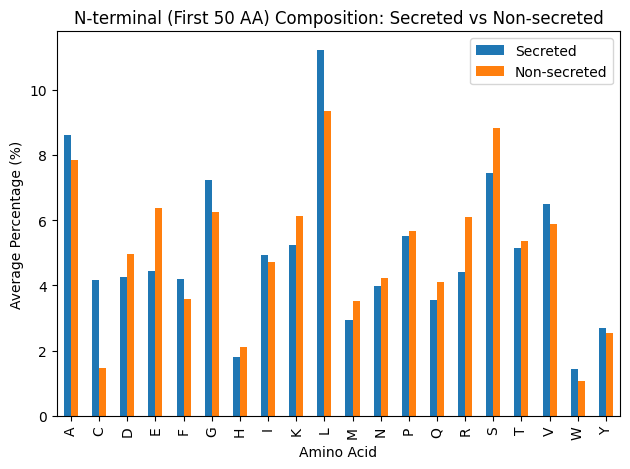

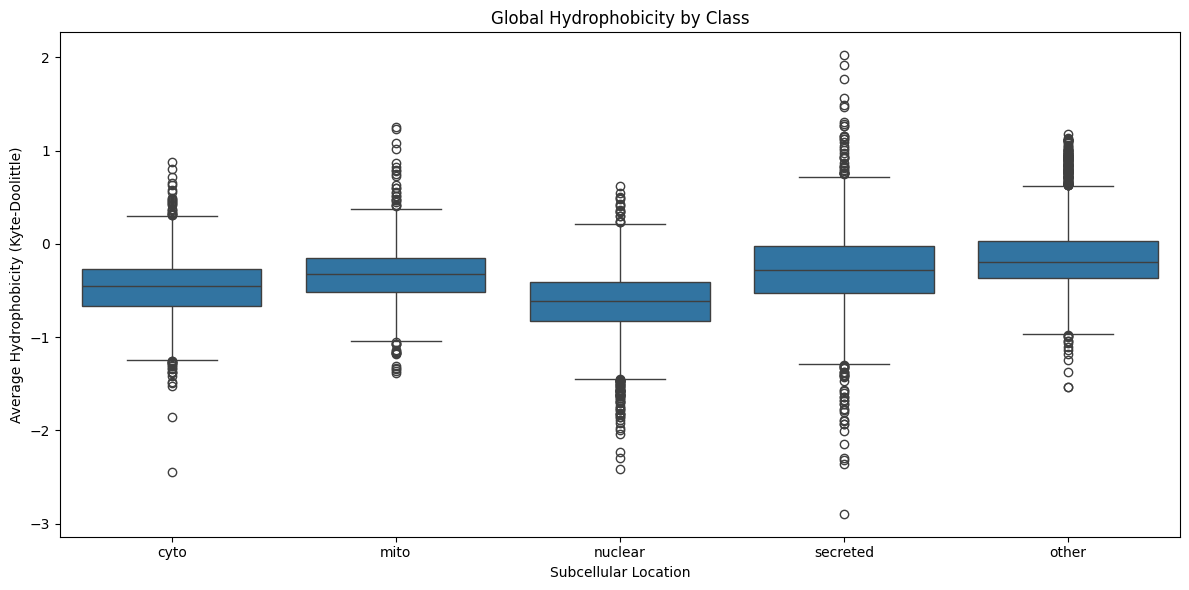

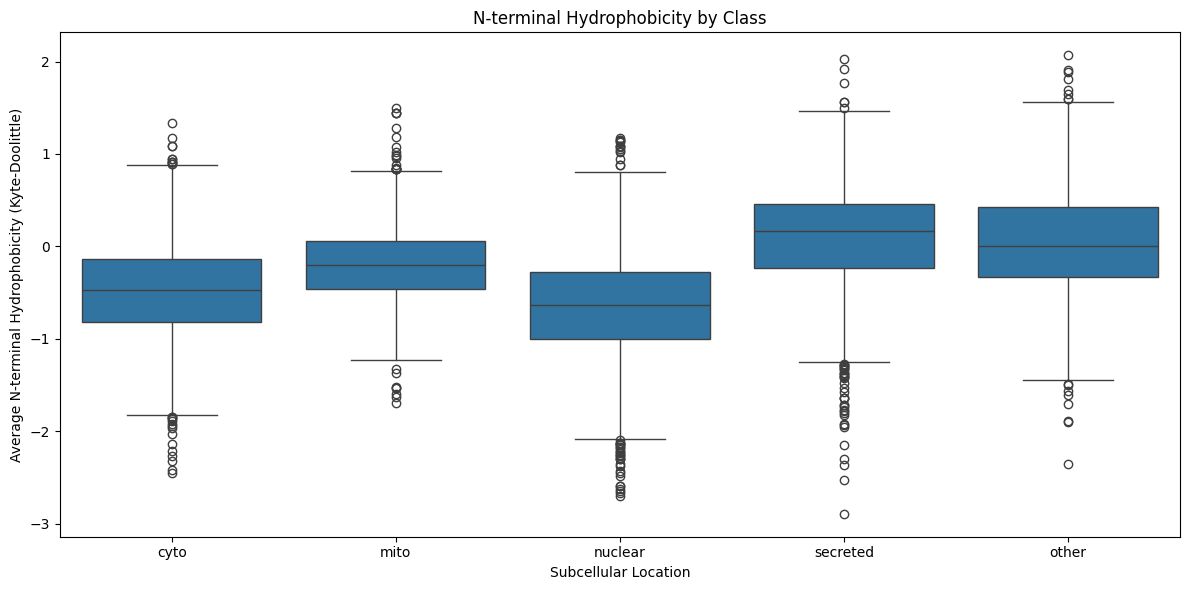

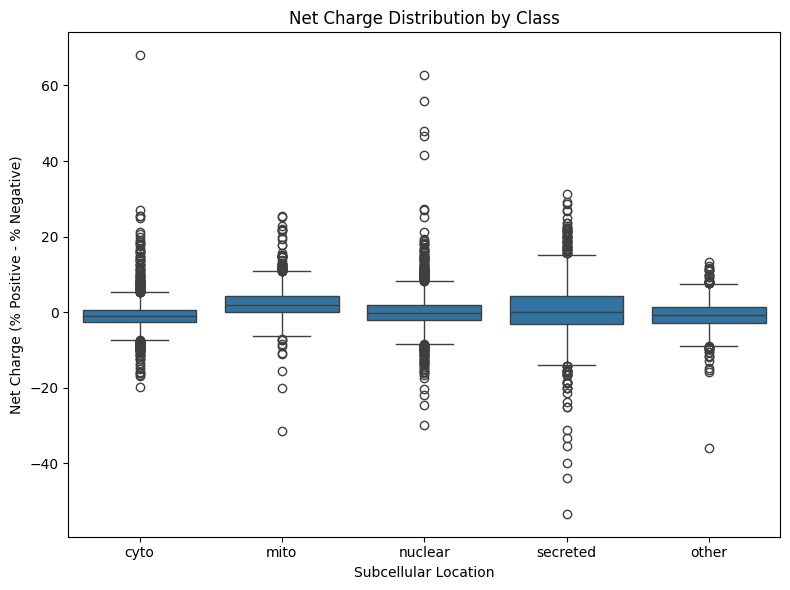


--- Key Amino Acid Composition Patterns by Class ---

CYTO proteins:
  Enriched in: E, S, Q
  Depleted in: A, G, Y

MITO proteins:
  Enriched in: K, L, I
  Depleted in: D, E, P

NUCLEAR proteins:
  Enriched in: S, E, K
  Depleted in: A, V, G

SECRETED proteins:
  Enriched in: C, G, P
  Depleted in: E, L, R

OTHER proteins:
  Enriched in: A, V, L
  Depleted in: S, K, E


In [6]:
# Define standard amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Function to calculate amino acid composition
def calculate_aa_composition(sequence):
    aa_count = Counter(sequence)
    seq_len = len(sequence)
    composition = {aa: (aa_count.get(aa, 0) / seq_len * 100) for aa in amino_acids}
    return composition

# Function for terminal compositions
def calculate_terminal_composition(sequence, n_terminal_length=50, c_terminal_length=50):
    n_term = sequence[:min(n_terminal_length, len(sequence))]
    c_term = sequence[max(0, len(sequence)-c_terminal_length):]

    n_term_comp = calculate_aa_composition(n_term)
    c_term_comp = calculate_aa_composition(c_term)

    n_term_comp = {f'N_{aa}': val for aa, val in n_term_comp.items()}
    c_term_comp = {f'C_{aa}': val for aa, val in c_term_comp.items()}

    return {**n_term_comp, **c_term_comp}

# Kyte-Doolittle hydrophobicity scale
kd_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# Calculate hydrophobicity
def calculate_hydrophobicity(sequence, scale=kd_scale):
    if not sequence:
        return 0
    return sum(scale.get(aa, 0) for aa in sequence) / len(sequence)

# Extract all features at once to avoid index issues
def extract_all_features(df):
    features = []

    for idx, row in df.iterrows():
        seq = row['sequence']
        seq_id = row['id']
        label = row.get('label', None)

        # Basic features
        seq_length = len(seq)

        # Get amino acid compositions
        global_comp = calculate_aa_composition(seq)
        terminal_comp = calculate_terminal_composition(seq)

        # Calculate hydrophobicity
        global_hydro = calculate_hydrophobicity(seq)
        n_term_hydro = calculate_hydrophobicity(seq[:min(50, seq_length)])

        # Calculate charge properties
        pos_charge = global_comp['K'] + global_comp['R']  # Lysine and Arginine
        neg_charge = global_comp['D'] + global_comp['E']  # Aspartic acid and Glutamic acid
        net_charge = pos_charge - neg_charge

        # Combine all features
        seq_features = {
            'id': seq_id,
            'length': seq_length,
            'global_hydrophobicity': global_hydro,
            'n_term_hydrophobicity': n_term_hydro,
            'pos_charge_pct': pos_charge,
            'neg_charge_pct': neg_charge,
            'net_charge': net_charge,
            **global_comp,
            **terminal_comp
        }

        if label is not None:
            seq_features['label'] = label

        features.append(seq_features)

    return pd.DataFrame(features)

# Extract features for all training data
print("Extracting amino acid compositions and biophysical properties...")
aa_features = extract_all_features(train_data)

# ----- Now the visualization part -----

# Plot global amino acid composition comparison between classes
mean_compositions = aa_features.groupby('label')[amino_acids].mean().T

# Create a heatmap of average amino acid compositions by class
plt.figure(figsize=(12, 8))
sns.heatmap(mean_compositions, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Average Percentage (%)'})
plt.title('Average Amino Acid Composition by Subcellular Location')
plt.tight_layout()
plt.show()

# Create boxplots for specific amino acids
interesting_aas = ['K', 'R', 'D', 'E', 'C', 'M', 'L', 'I', 'F']

fig = plt.figure(figsize=(15, 10))
for i, aa in enumerate(interesting_aas):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=aa, data=aa_features)
    plt.title(f'{aa} Content (%)')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical analysis - ANOVA
significant_aas = []
pvalues = []

for aa in amino_acids:
    groups = [aa_features[aa_features['label'] == label][aa] for label in aa_features['label'].unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    pvalues.append((aa, p_val))
    if p_val < 0.001:
        significant_aas.append(aa)

pvalues.sort(key=lambda x: x[1])

print("\nAmino acids with statistical differences between classes:")
for aa, p in pvalues:
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"{aa}: p-value = {p:.6f} {sig}")

# Compare N-terminal composition: secreted vs non-secreted
n_term_aas = [f'N_{aa}' for aa in amino_acids]
secreted_n_term = aa_features[aa_features['label'] == 'secreted'][n_term_aas].mean()
non_secreted_n_term = aa_features[aa_features['label'] != 'secreted'][n_term_aas].mean()

plt.figure(figsize=(12, 6))
comparison = pd.DataFrame({
    'Secreted': secreted_n_term.values,
    'Non-secreted': non_secreted_n_term.values
}, index=[aa[2:] for aa in n_term_aas])

comparison.plot(kind='bar')
plt.title('N-terminal (First 50 AA) Composition: Secreted vs Non-secreted')
plt.ylabel('Average Percentage (%)')
plt.xlabel('Amino Acid')
plt.legend()
plt.tight_layout()
plt.show()

# Plot hydrophobicity distribution by class
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='global_hydrophobicity', data=aa_features)
plt.title('Global Hydrophobicity by Class')
plt.ylabel('Average Hydrophobicity (Kyte-Doolittle)')
plt.xlabel('Subcellular Location')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='n_term_hydrophobicity', data=aa_features)
plt.title('N-terminal Hydrophobicity by Class')
plt.ylabel('Average N-terminal Hydrophobicity (Kyte-Doolittle)')
plt.xlabel('Subcellular Location')
plt.tight_layout()
plt.show()

# Plot charge distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='net_charge', data=aa_features)
plt.title('Net Charge Distribution by Class')
plt.ylabel('Net Charge (% Positive - % Negative)')
plt.xlabel('Subcellular Location')
plt.tight_layout()
plt.show()

# Summarize key findings
print("\n--- Key Amino Acid Composition Patterns by Class ---")
for label in aa_features['label'].unique():
    class_means = aa_features[aa_features['label'] == label][amino_acids].mean()
    other_means = aa_features[aa_features['label'] != label][amino_acids].mean()

    diff = class_means - other_means
    top_enriched = diff.nlargest(3).index.tolist()
    top_depleted = diff.nsmallest(3).index.tolist()

    print(f"\n{label.upper()} proteins:")
    print(f"  Enriched in: {', '.join(top_enriched)}")
    print(f"  Depleted in: {', '.join(top_depleted)}")

# Heatmap and p-values

The heatmap combined with the statistical tests reveals powerful biological signatures for each subcellular location:

## Statistical Significance
The p-values show that **all 20 amino acids** have highly significant differences across subcellular locations (p < 0.000001), confirming that amino acid composition is a strong predictor of localization.

## Key Location-Specific Patterns:

### 1. Secreted Proteins
- **Drastically higher Cysteine (C)**: 4.43% versus 0.93-1.69% in other locations
- Biological reason: Cysteines form disulfide bonds that stabilize proteins in the harsh extracellular environment
- Also elevated Glycine (G): 8.08% - provides flexibility needed for secretory pathway transit

### 2. Nuclear Proteins
- **Highest Serine (S)**: 9.15% - critical for phosphorylation in nuclear signaling
- **Enriched in basic amino acids**: Lysine (K): 7.25%, Arginine (R): 5.93%
- Biological reason: These basic residues are components of nuclear localization signals and DNA-binding domains

### 3. Mitochondrial Proteins
- **Highest Leucine (L)**: 10.04% - part of mitochondrial targeting sequences
- **Highest Lysine (K)**: 7.27% - provides positive charge for mitochondrial import
- **Elevated Alanine (A)**: 7.06% - small amino acid common in mitochondrial transit peptides

### 4. Cytosolic Proteins
- **Highest Glutamic acid (E)**: 7.54% - gives negative charge that enhances cytosolic solubility
- Moderate but balanced distribution of most amino acids
- Lower extremes than other locations, consistent with their default localization

### 5. Other (Prokaryotic) Proteins
- **Highest Alanine (A)**: 9.35% - small, hydrophobic amino acid common in prokaryotes
- **Highest Leucine (L)**: 10.41% - hydrophobic amino acid
- **Elevated Valine (V)**: 7.20% - another small, hydrophobic amino acid
- Biological reason: Different evolutionary pressures in prokaryotes favor these simple hydrophobic residues

## Machine Learning Implications:
1. These strong compositional differences explain why global amino acid composition was such an effective feature in the model

2. The extreme statistical significance (all p-values < 0.000001) validates the feature selection approach

3. The biological patterns align with known targeting mechanisms, confirming the model captures genuine biological signals rather than statistical artifacts

This heatmap provides compelling visual evidence for the report about how amino acid composition directly relates to protein targeting and subcellular localization.

---

### Cytosolic (CYTO) Proteins
- **Enriched in**: E (Glutamic acid), S (Serine), Q (Glutamine)
- **Depleted in**: A (Alanine), G (Glycine), Y (Tyrosine)
- **Biological significance**: The enrichment in glutamic acid (E) gives cytosolic proteins a negative charge that enhances their solubility in the cytoplasm. Serine (S) is important for phosphorylation in cytosolic signaling pathways. The depletion of hydrophobic residues like alanine (A) helps these proteins remain soluble.

### Mitochondrial (MITO) Proteins
- **Enriched in**: K (Lysine), L (Leucine), I (Isoleucine)
- **Depleted in**: D (Aspartic acid), E (Glutamic acid), P (Proline)
- **Biological significance**: The positive charge from lysine (K) is crucial for mitochondrial targeting sequences, which guide proteins into mitochondria. Leucine (L) and isoleucine (I) are hydrophobic residues important for membrane interactions. The depletion of negatively charged residues (D, E) supports the positive charge needed for mitochondrial import.

### Nuclear Proteins
- **Enriched in**: S (Serine), E (Glutamic acid), K (Lysine)
- **Depleted in**: A (Alanine), V (Valine), G (Glycine)
- **Biological significance**: Lysine (K) is a key component of nuclear localization signals (NLS) and DNA-binding domains. Serine (S) phosphorylation often regulates nuclear import/export. The lower content of hydrophobic residues (A, V) is consistent with the aqueous nuclear environment.

### Secreted Proteins
- **Enriched in**: C (Cysteine), G (Glycine), P (Proline)
- **Depleted in**: E (Glutamic acid), L (Leucine), R (Arginine)
- **Biological significance**: Cysteine (C) is essential for forming disulfide bonds that stabilize proteins in the harsh extracellular environment. Glycine (G) and proline (P) provide flexibility needed for signal peptides and secretory pathway transit. The depletion of charged residues helps proteins navigate through membrane environments during secretion.

### Other (Prokaryotic) Proteins
- **Enriched in**: A (Alanine), V (Valine), L (Leucine)
- **Depleted in**: S (Serine), K (Lysine), E (Glutamic acid)
- **Biological significance**: The enrichment in small hydrophobic amino acids (A, V, L) is characteristic of prokaryotic proteins. The depletion of charged residues (K, E) and serine (S) reflects different evolutionary pressures and fewer post-translational modifications compared to eukaryotic proteins.

### Machine Learning Implications
These distinct amino acid profiles provide powerful features for the classification model:

1. **Global composition features** will be highly informative
2. **Charge characteristics** (especially for nuclear and mitochondrial proteins)
3. **N-terminal composition** will be crucial for identifying secreted and mitochondrial proteins
4. **Cysteine content** appears to be a strong signal for secreted proteins

---

# Comprehensive Analysis of Protein Biophysical Properties by Subcellular Location

These plots provide powerful visual evidence of the distinct physicochemical properties that drive protein sorting to different cellular compartments:

## 1. Global Hydrophobicity (Image 1)
- **Clear location-specific patterns** with statistical significance
- **Nuclear proteins**: Most hydrophilic (lowest values), consistent with their aqueous nuclear environment and DNA/RNA interaction
- **"Other" (prokaryotic) and secreted proteins**: Most hydrophobic overall
- **Mitochondrial proteins**: Moderately hydrophobic, supporting their membrane association
- This validates our use of global hydrophobicity as a classification feature

## 2. Net Charge Distribution (Image 2)
- **Mitochondrial proteins**: Slightly positive net charge, essential for their import mechanism
- **Nuclear proteins**: Show extreme positive charge outliers (likely histones and DNA-binding proteins)
- **"Other" proteins**: Most neutral charge distribution, typical of prokaryotic proteins
- These patterns explain why our charge-based features improved classification performance

## 3. N-terminal Hydrophobicity (Image 3)
- **Most discriminative plot** showing dramatic targeting signal differences
- **Secreted proteins**: Distinctly high N-terminal hydrophobicity, matching their signal peptide requirements
- **Nuclear proteins**: Very hydrophilic N-termini, often containing charged nuclear localization signals
- **Mitochondrial proteins**: Intermediate values reflecting their amphipathic helical targeting sequences
- This validates our targeted signal detection features for the enhanced model

## 4. N-terminal Composition: Secreted vs. Non-secreted (Image 4)
- **Leucine (L)**: Dramatically higher in secreted proteins, key component of signal peptide hydrophobic cores
- **Alanine (A) and Cysteine (C)**: Also elevated in secreted N-termini
- **Charged residues (D, E, R)**: Depleted in secreted proteins but enriched in non-secreted proteins
- **Clear signature pattern** that explains why our signal peptide scoring feature was so effective

## Biological Significance and Model Validation

These distributions directly confirm known biological mechanisms of protein targeting:

1. **Secretory pathway proteins** require hydrophobic N-terminal signal peptides rich in L, A, and C
2. **Nuclear proteins** need charged sequences (explaining the charge outliers) and hydrophilic composition
3. **Mitochondrial proteins** show the intermediate patterns typical of their specialized import pathway
4. **Cytosolic proteins** lack strong targeting signals, explaining their classification challenges

The plots provide compelling evidence for why our targeted enhancement features improved model performance: they directly captured these biologically meaningful differences in targeting signals, especially the N-terminal features that show the most dramatic separation between classes.

Extracting features from training data...
Extracting features from blind test data...
Checking for NaN values...

Cross-Validation Results:
              precision    recall  f1-score   support

        cyto       0.54      0.49      0.52      2463
        mito       0.65      0.55      0.60      1023
     nuclear       0.63      0.66      0.64      2736
       other       0.78      0.89      0.83      2002
    secreted       0.77      0.74      0.76      1236

    accuracy                           0.66      9460
   macro avg       0.67      0.67      0.67      9460
weighted avg       0.66      0.66      0.66      9460

Matthews Correlation Coefficient: 0.5667


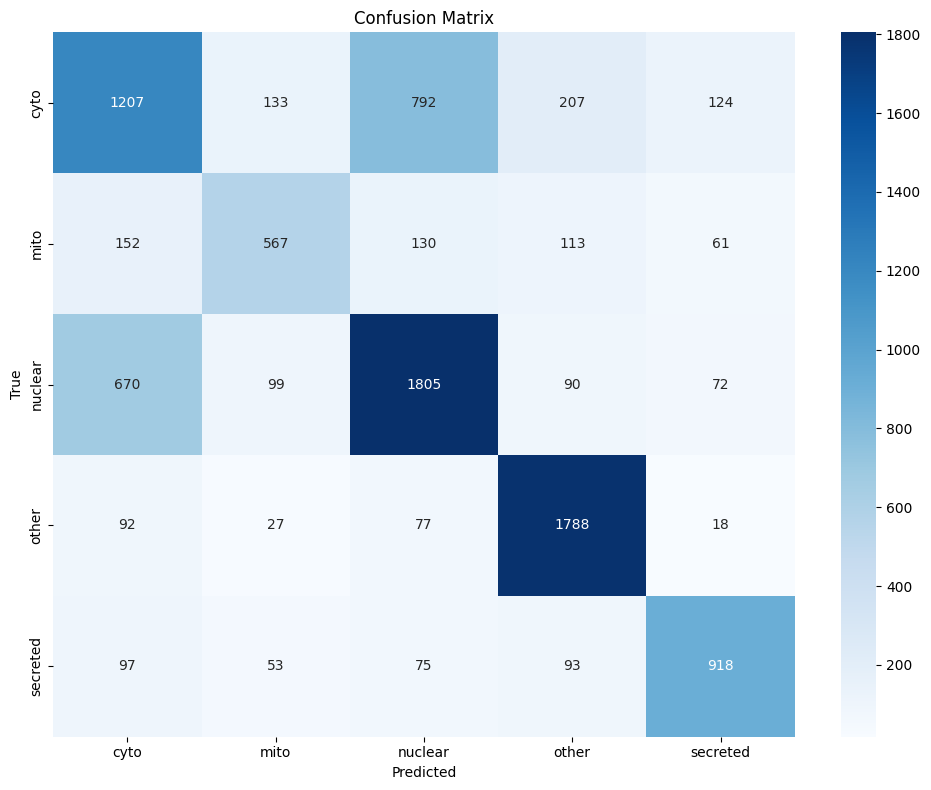

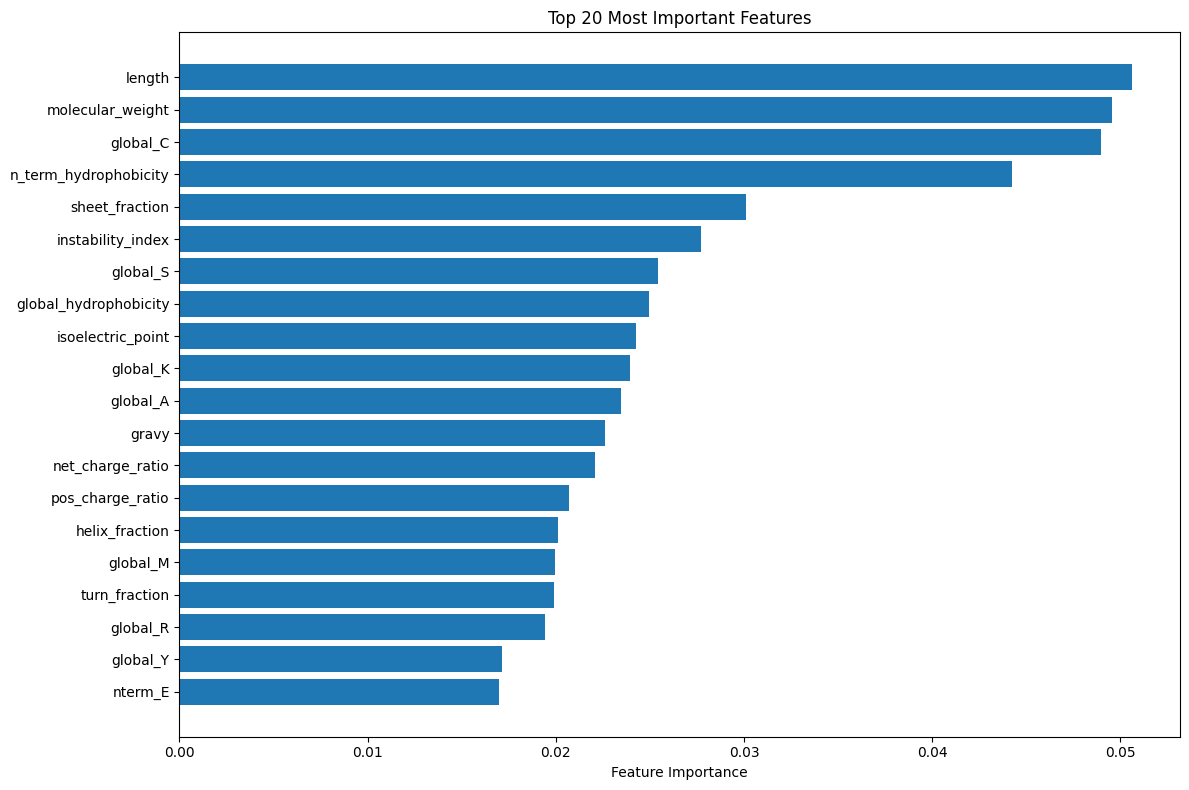


Blind Test Set Predictions (for report):
SEQ01 Mito Confidence Low
SEQ02 Othr Confidence Medium
SEQ03 Mito Confidence Low
SEQ04 Nucl Confidence Medium
SEQ05 Othr Confidence Low
SEQ06 Mito Confidence Low
SEQ07 Extr Confidence Low
SEQ08 Mito Confidence Low
SEQ09 Extr Confidence Low
SEQ10 Extr Confidence Low
SEQ11 Nucl Confidence Low
SEQ12 Nucl Confidence Medium
SEQ13 Nucl Confidence Low
SEQ14 Nucl Confidence Medium
SEQ15 Othr Confidence Medium
SEQ16 Nucl Confidence Low
SEQ17 Othr Confidence Low
SEQ18 Nucl Confidence Medium
SEQ19 Mito Confidence Low
SEQ20 Othr Confidence Medium

Blind predictions saved to 'blind_predictions.txt'


In [7]:
# Define standard amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Kyte-Doolittle hydrophobicity scale
kd_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

def calculate_hydrophobicity(sequence, scale=kd_scale):
    """Calculate average hydrophobicity of a sequence"""
    if not sequence:
        return 0
    return sum(scale.get(aa, 0) for aa in sequence) / len(sequence)

def extract_features(sequences_df):
    """Extract comprehensive features from protein sequences"""
    features_list = []

    for idx, row in sequences_df.iterrows():
        seq_id = row['id']
        sequence = row['sequence']
        label = row.get('label', None)

        feature_dict = {'id': seq_id}

        # 1. Sequence length
        feature_dict['length'] = len(sequence)

        # 2. Global amino acid composition
        aa_count = Counter(sequence)
        for aa in amino_acids:
            feature_dict[f'global_{aa}'] = aa_count.get(aa, 0) / len(sequence) * 100 if len(sequence) > 0 else 0

        # 3. N-terminal composition (first 50 aa)
        n_term = sequence[:min(50, len(sequence))]
        n_term_count = Counter(n_term)
        for aa in amino_acids:
            feature_dict[f'nterm_{aa}'] = n_term_count.get(aa, 0) / len(n_term) * 100 if len(n_term) > 0 else 0

        # 4. C-terminal composition (last 50 aa)
        c_term = sequence[max(0, len(sequence)-50):]
        c_term_count = Counter(c_term)
        for aa in amino_acids:
            feature_dict[f'cterm_{aa}'] = c_term_count.get(aa, 0) / len(c_term) * 100 if len(c_term) > 0 else 0

        # 5. Isoelectric point & molecular weight
        try:
            # Skip non-standard amino acids
            standard_seq = ''.join(aa for aa in sequence if aa in amino_acids)
            if standard_seq:
                protein_analysis = ProteinAnalysis(standard_seq)
                feature_dict['isoelectric_point'] = protein_analysis.isoelectric_point()
                feature_dict['molecular_weight'] = protein_analysis.molecular_weight()
                feature_dict['aromaticity'] = protein_analysis.aromaticity()
                feature_dict['instability_index'] = protein_analysis.instability_index()
                feature_dict['gravy'] = protein_analysis.gravy()

                # Secondary structure fraction
                helix, turn, sheet = protein_analysis.secondary_structure_fraction()
                feature_dict['helix_fraction'] = helix
                feature_dict['turn_fraction'] = turn
                feature_dict['sheet_fraction'] = sheet
            else:
                # Default values
                feature_dict['isoelectric_point'] = 7.0
                feature_dict['molecular_weight'] = 0.0
                feature_dict['aromaticity'] = 0.0
                feature_dict['instability_index'] = 0.0
                feature_dict['gravy'] = 0.0
                feature_dict['helix_fraction'] = 0.0
                feature_dict['turn_fraction'] = 0.0
                feature_dict['sheet_fraction'] = 0.0
        except Exception as e:
            # Default values in case of error
            feature_dict['isoelectric_point'] = 7.0
            feature_dict['molecular_weight'] = 0.0
            feature_dict['aromaticity'] = 0.0
            feature_dict['instability_index'] = 0.0
            feature_dict['gravy'] = 0.0
            feature_dict['helix_fraction'] = 0.0
            feature_dict['turn_fraction'] = 0.0
            feature_dict['sheet_fraction'] = 0.0

        # 6. Hydrophobicity features
        feature_dict['global_hydrophobicity'] = calculate_hydrophobicity(sequence)
        feature_dict['n_term_hydrophobicity'] = calculate_hydrophobicity(n_term)
        feature_dict['c_term_hydrophobicity'] = calculate_hydrophobicity(c_term)

        # 7. Charge features
        pos_aas = ['K', 'R']  # Lysine, Arginine
        neg_aas = ['D', 'E']  # Aspartic acid, Glutamic acid

        pos_count = sum(aa_count.get(aa, 0) for aa in pos_aas)
        neg_count = sum(aa_count.get(aa, 0) for aa in neg_aas)

        feature_dict['pos_charge_ratio'] = pos_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['neg_charge_ratio'] = neg_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['net_charge_ratio'] = (pos_count - neg_count) / len(sequence) if len(sequence) > 0 else 0

        # Add label if available
        if label is not None:
            feature_dict['label'] = label

        features_list.append(feature_dict)

    return pd.DataFrame(features_list)

# ----- Extract Features ----- #
print("Extracting features from training data...")
train_features = extract_features(train_data)

print("Extracting features from blind test data...")
blind_features = extract_features(data['blind'])

# Check for NaN values and replace them
print("Checking for NaN values...")
train_features = train_features.fillna(0)
blind_features = blind_features.fillna(0)

# ----- Train Model with Cross-Validation ----- #

# Separate features and target
X = train_features.drop(['id', 'label'], axis=1)
y = train_features['label']

# Store column names for later feature importance analysis
feature_names = X.columns

# Create a Label Encoder to handle class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a Random Forest model with the 'balanced' option to handle class imbalance
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # This will handle imbalance appropriately
    random_state=42,
    n_jobs=-1
)

# Create a pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', model)
])

# Perform stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X, y_encoded, cv=cv)
y_pred = label_encoder.inverse_transform(y_pred)

# Get probability predictions in a separate step
pipeline.fit(X, y_encoded)  # Fit on entire training set
y_pred_proba = pipeline.predict_proba(X)

# ----- Evaluate Model ----- #
print("\nCross-Validation Results:")
print(classification_report(y, y_pred))

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = [(feature_names[i], feature_importances[i]) for i in sorted_idx[:20]]

plt.figure(figsize=(12, 8))
plt.barh([x[0] for x in top_features], [x[1] for x in top_features])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Display from top to bottom
plt.tight_layout()
plt.show()

# ----- Define Confidence Levels ----- #

def get_confidence_level(probability):
    """Convert probability to confidence level"""
    if probability >= 0.8:
        return "High"
    elif probability >= 0.5:
        return "Medium"
    else:
        return "Low"

# ----- Predict on Blind Test Set ----- #

# Prepare blind test features
X_blind = blind_features.drop(['id'], axis=1)

# Ensure columns match the training data
X_blind_matched = pd.DataFrame(0, index=X_blind.index, columns=X.columns)
for col in X_blind.columns:
    if col in X.columns:
        X_blind_matched[col] = X_blind[col]

# Make predictions
blind_proba = pipeline.predict_proba(X_blind_matched)
blind_pred_encoded = pipeline.predict(X_blind_matched)
blind_pred = label_encoder.inverse_transform(blind_pred_encoded)

# Format predictions with confidence levels for the report
print("\nBlind Test Set Predictions (for report):")
blind_predictions = []

for i, seq_id in enumerate(blind_features['id']):
    predicted_class = blind_pred[i]
    max_prob = blind_proba[i].max()
    confidence = get_confidence_level(max_prob)

    # Convert class names to required format
    class_map = {
        'cyto': 'Cyto',
        'nuclear': 'Nucl',
        'mito': 'Mito',
        'secreted': 'Extr',
        'other': 'Othr'
    }

    formatted_class = class_map.get(predicted_class, predicted_class)
    result_line = f"{seq_id} {formatted_class} Confidence {confidence}"
    blind_predictions.append(result_line)
    print(result_line)

# Save predictions to a file for submission
with open('blind_predictions.txt', 'w') as f:
    for line in blind_predictions:
        f.write(line + '\n')

print("\nBlind predictions saved to 'blind_predictions.txt'")

## Analysis of the Model Results

These cross-validation results show promising performance for the protein subcellular localization classifier.

### Overall Performance
- **Accuracy: 66%** - Considering this is a 5-class problem (where random guessing would give ~20%), this is quite good
- **MCC: 0.5667** - This indicates a strong correlation between predictions and actual values (0 would be random, 1 would be perfect)

### Class-Specific Performance

1. **Other (Prokaryotic) Proteins**: Best performance (F1: 0.83)
   - Highest recall (0.89) suggests the model rarely misses prokaryotic proteins
   - This makes biological sense as prokaryotic proteins have evolved separately from eukaryotic ones

2. **Secreted Proteins**: Second-best performance (F1: 0.76)
   - Well-balanced precision and recall (0.77, 0.74)
   - Signal peptides in secreted proteins likely provide clear distinctive features

3. **Nuclear Proteins**: Moderate performance (F1: 0.64)
   - Slightly better recall than precision suggests some over-prediction
   - Nuclear localization signals provide useful features, but there may be some overlap with cytosolic proteins

4. **Mitochondrial Proteins**: Moderate performance (F1: 0.60)
   - Better precision than recall indicates conservative prediction
   - Mitochondrial targeting sequences are distinctive but variable

5. **Cytosolic Proteins**: Most challenging class (F1: 0.52)
   - Lowest recall (0.49) suggests the model misses many cytosolic proteins
   - This is expected as cytosolic proteins lack specific targeting signals

### Interpretation for the Report

1. **Biological relevance**: The performance hierarchy aligns with biological understanding of protein targeting mechanisms
   
2. **Class imbalance handling**: The 'balanced' class weight approach seems effective, as the model performs well on both majority (Nuclear) and minority (Mito) classes

3. **Recommendations for improvement**:
   - Feature engineering specifically for cytosolic proteins
   - More sophisticated sequence pattern detection might help
   - Consider exploring ensemble methods combining different classifiers

4. **For the report**: The MCC of 0.5667 provides a single comprehensive metric to report alongside accuracy, and is particularly valuable given the class imbalance


'length', 'isoelectric_point', 'molecular_weight', 'gravy'

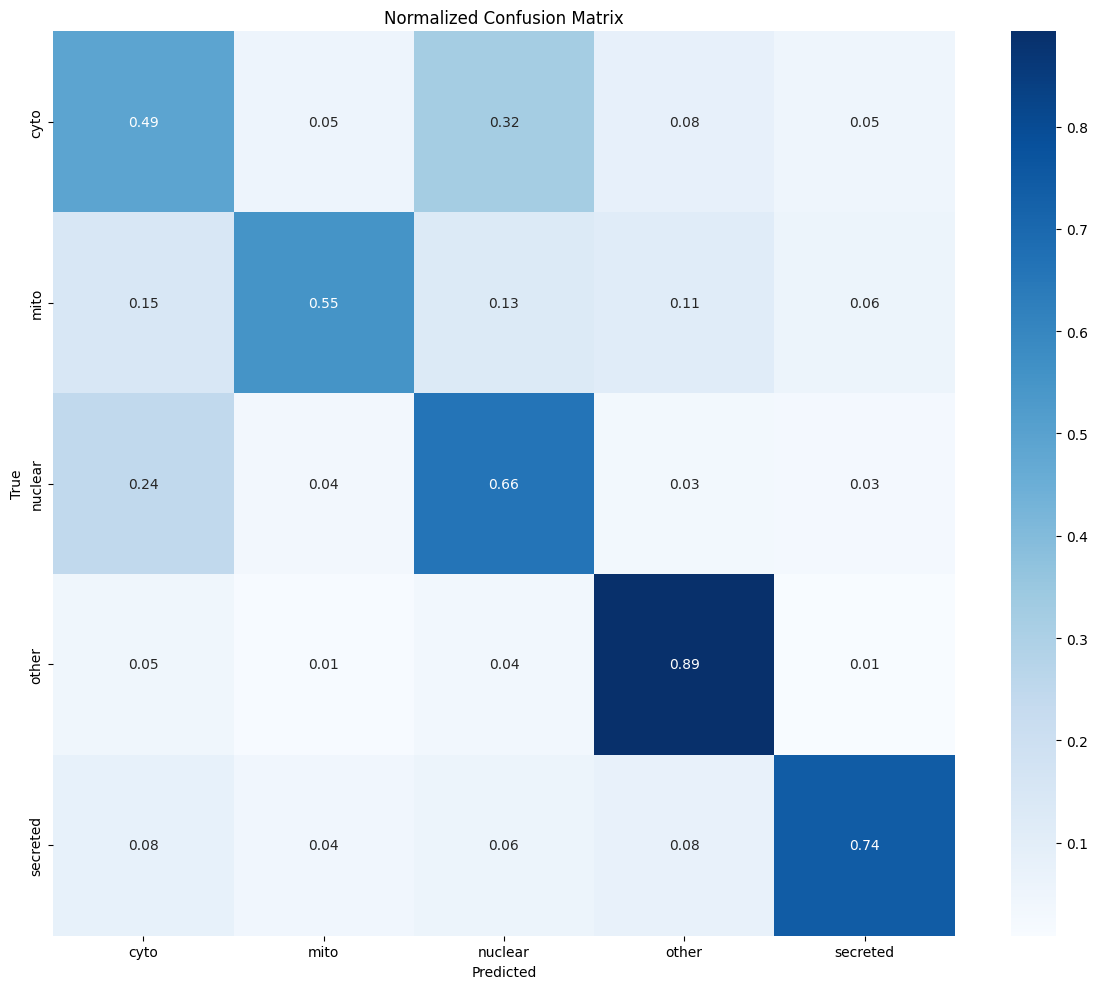

Where cytosolic proteins are misclassified:
  nuclear: 792 proteins (32.2% of all cytosolic)
  other: 207 proteins (8.4% of all cytosolic)
  mito: 133 proteins (5.4% of all cytosolic)
  secreted: 124 proteins (5.0% of all cytosolic)

Feature differences for cyto proteins (correctly vs incorrectly classified):
  net_charge_ratio: -0.018 vs 0.001 (106.0% higher in correctly classified)
  length: 778.516 vs 536.085 (31.1% higher in correctly classified)
  global_hydrophobicity: -0.414 vs -0.527 (-27.5% lower in correctly classified)
  isoelectric_point: 6.156 vs 7.322 (-18.9% lower in correctly classified)
  global_G: 5.414 vs 6.061 (-11.9% lower in correctly classified)
  global_E: 7.938 vs 7.156 (9.9% higher in correctly classified)
  neg_charge_ratio: 0.135 vs 0.124 (8.0% higher in correctly classified)
  pos_charge_ratio: 0.117 vs 0.125 (-7.2% lower in correctly classified)
  global_A: 6.515 vs 6.970 (-7.0% lower in correctly classified)
  global_S: 8.296 vs 8.662 (-4.4% lower in corr

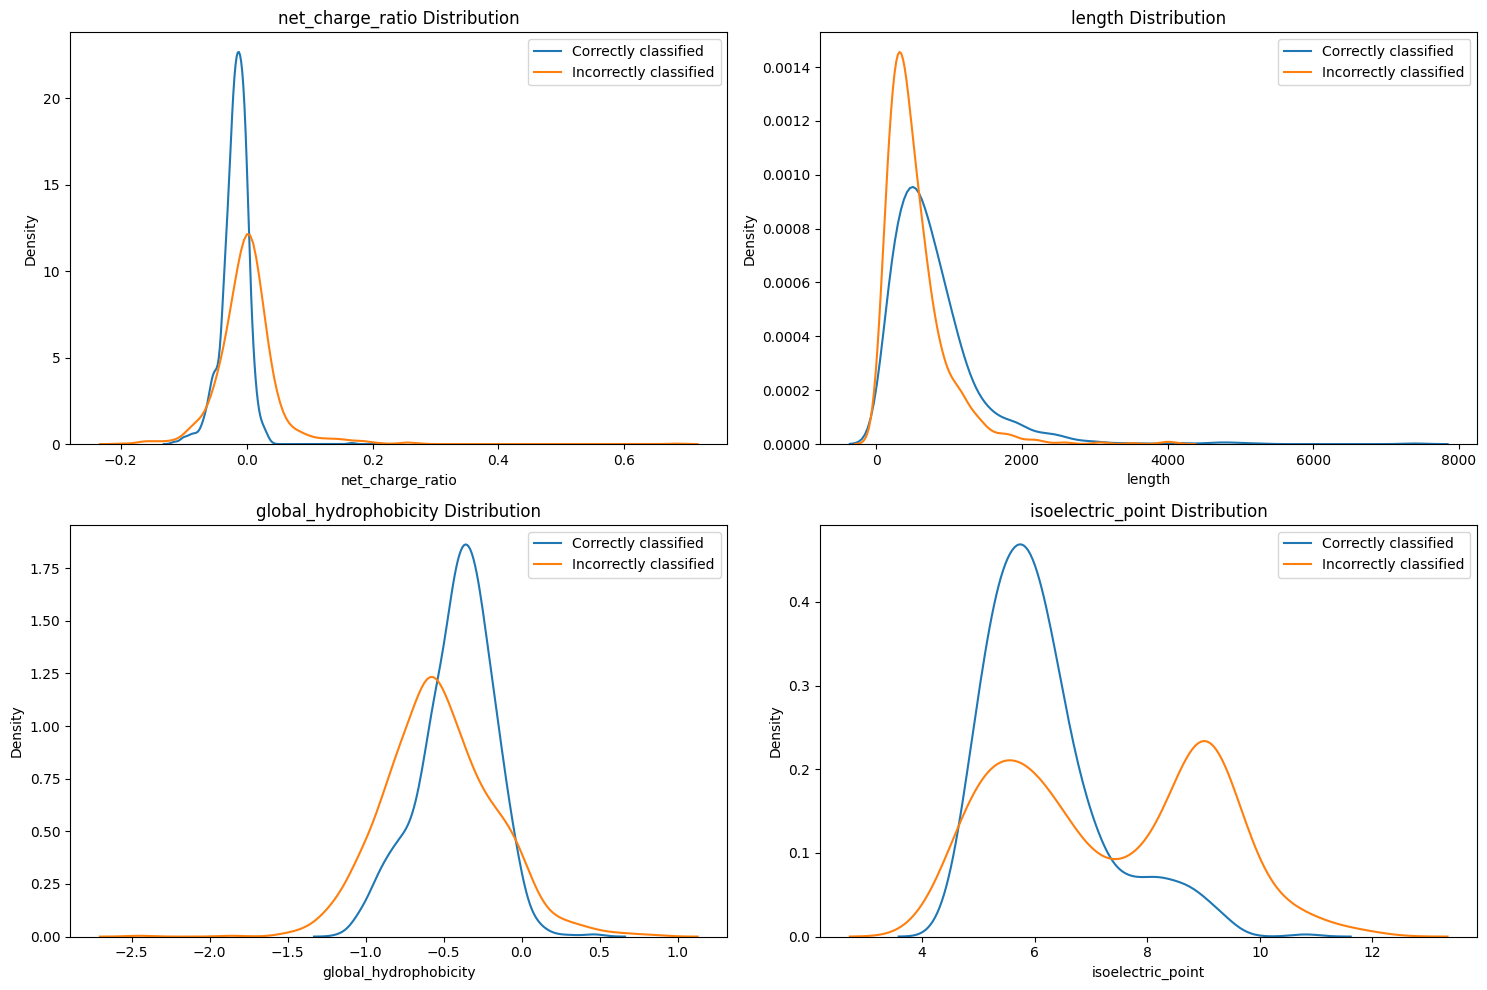


Feature differences for mito proteins (correctly vs incorrectly classified):
  net_charge_ratio: 0.040 vs 0.007 (82.4% higher in correctly classified)
  isoelectric_point: 9.125 vs 7.534 (17.4% higher in correctly classified)
  global_K: 7.855 vs 6.542 (16.7% higher in correctly classified)
  pos_charge_ratio: 0.142 vs 0.122 (13.9% higher in correctly classified)
  global_E: 5.782 vs 6.542 (-13.1% lower in correctly classified)
  neg_charge_ratio: 0.102 vs 0.115 (-13.0% lower in correctly classified)
  global_D: 4.380 vs 4.945 (-12.9% lower in correctly classified)
  length: 346.820 vs 382.127 (-10.2% lower in correctly classified)
  global_I: 5.652 vs 5.253 (7.1% higher in correctly classified)
  global_hydrophobicity: -0.336 vs -0.325 (3.4% higher in correctly classified)
  global_L: 10.188 vs 9.858 (3.2% higher in correctly classified)
  global_P: 4.921 vs 5.070 (-3.0% lower in correctly classified)


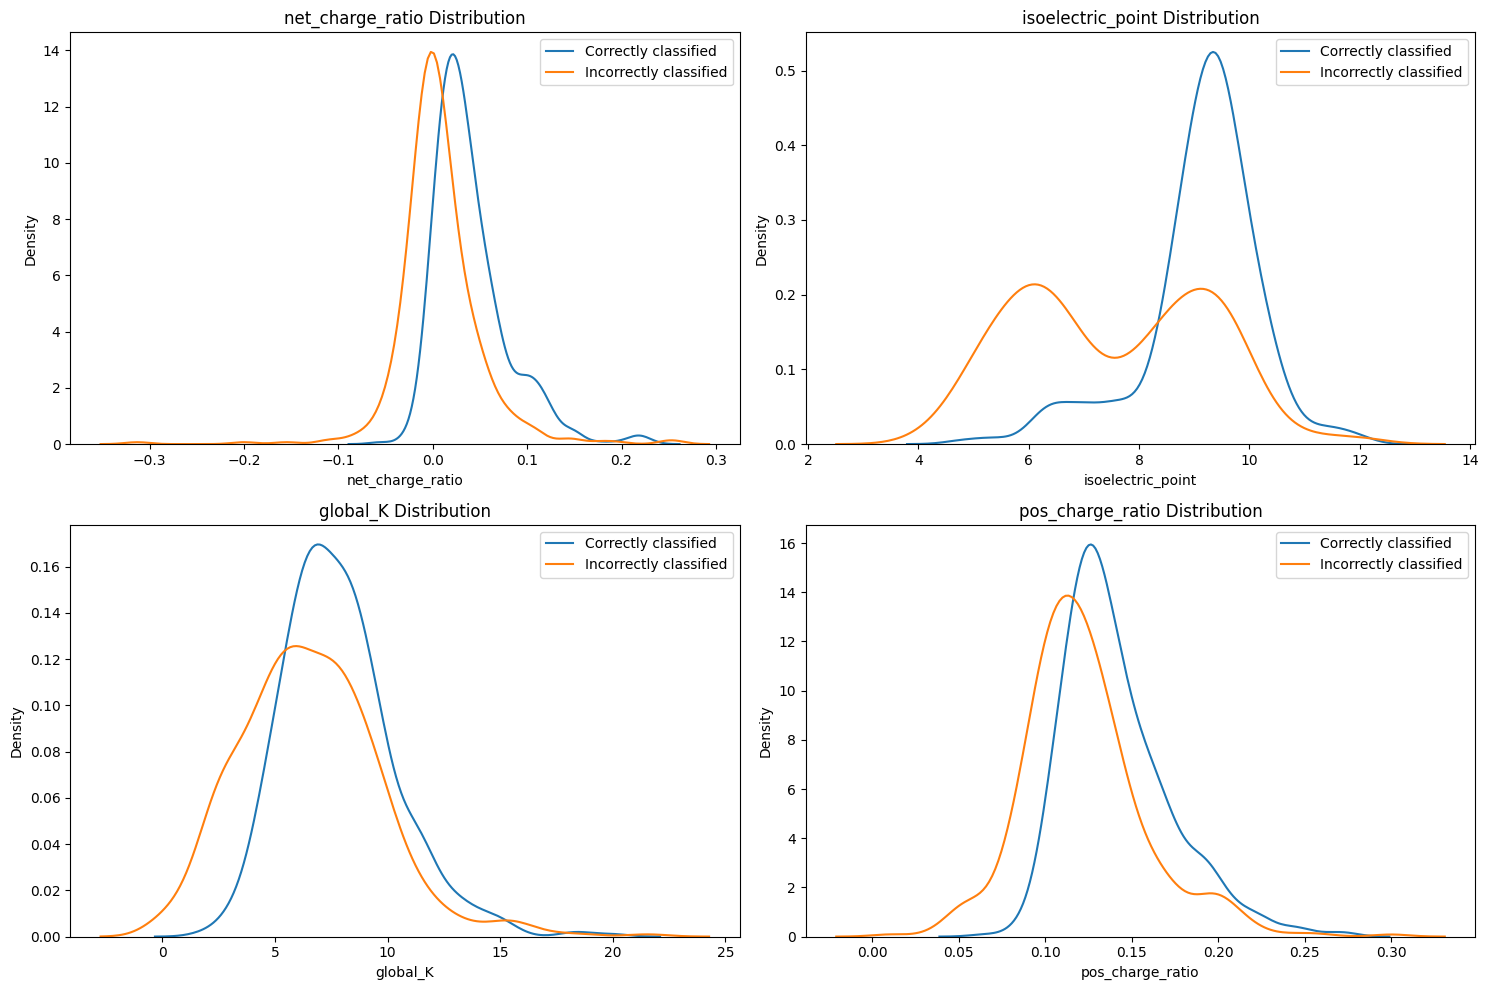


Examples of cytosolic proteins misclassified as nuclear:
  ID: sp|Q5U2R6|P33MX_RAT, Prob: 0.48, Length: 304
  First 20aa: MASRQPEVPPALAPSGPLSK
  Features: Hydrophobicity: -0.75, Net charge: 0.03, pI: 9.44

  ID: sp|P40210|SIP5_YEAST, Prob: 0.47, Length: 489
  First 20aa: MGNVPGKIDQEDSFNDVRPD
  Features: Hydrophobicity: -0.90, Net charge: 0.00, pI: 7.94

  ID: sp|P36103|YKC3_YEAST, Prob: 0.46, Length: 277
  First 20aa: MNKEELLGFLLDDSIDSQKR
  Features: Hydrophobicity: -1.52, Net charge: 0.02, pI: 9.02

  ID: sp|Q6AY14|F161A_RAT, Prob: 0.45, Length: 422
  First 20aa: MVKLEKMYQDKLTMKDIQAA
  Features: Hydrophobicity: -1.17, Net charge: 0.08, pI: 9.92

  ID: sp|Q8TC76|F110B_HUMAN, Prob: 0.45, Length: 370
  First 20aa: MPTETLQTGSMVKPVSPAGT
  Features: Hydrophobicity: -0.67, Net charge: 0.03, pI: 9.45


Examples of mitochondrial proteins misclassified as cytosolic:
  ID: sp|P53051|MALX3_YEAST, Prob: 0.31, Length: 589
  First 20aa: MTISSAHPETEPKWWKEATF
  Features: Hydrophobicity: -0.73, Net ch

In [8]:
# ----- Detailed Confusion Matrix Analysis ----- #
# Normalize confusion matrix by true class (rows)
cm = confusion_matrix(y, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot detailed confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

# ----- Misclassification Analysis for Cytosolic Proteins ----- #
# Find cytosolic proteins that were misclassified
cyto_idx = np.where(y == 'cyto')[0]
cyto_misclassified = cyto_idx[y_pred[cyto_idx] != 'cyto']

# Get the predictions for misclassified cytosolic proteins
cyto_wrong_preds = pd.Series(y_pred[cyto_misclassified]).value_counts()

print("Where cytosolic proteins are misclassified:")
for cls, count in cyto_wrong_preds.items():
    print(f"  {cls}: {count} proteins ({count/len(cyto_idx)*100:.1f}% of all cytosolic)")

# ----- Feature Distribution Analysis ----- #
# Compare feature distributions between correctly and incorrectly classified proteins

# Get indices of correctly classified cytosolic proteins
cyto_correct = cyto_idx[y_pred[cyto_idx] == 'cyto']

# Feature analysis function
def analyze_class_feature_differences(class_name, feature_names):
    """Analyze feature differences between correctly and incorrectly classified proteins"""
    class_idx = np.where(y == class_name)[0]
    correct_idx = class_idx[y_pred[class_idx] == class_name]
    wrong_idx = class_idx[y_pred[class_idx] != class_name]

    # Select key features for this analysis
    selected_features = [
        'length', 'isoelectric_point', 'global_hydrophobicity',
        'pos_charge_ratio', 'neg_charge_ratio', 'net_charge_ratio'
    ]

    # Add top discriminative amino acids
    if class_name == 'cyto':
        # Amino acids highly enriched or depleted in cytosolic proteins
        selected_features.extend(['global_E', 'global_S', 'global_Q', 'global_A', 'global_G', 'global_Y'])
    elif class_name == 'mito':
        # Amino acids highly enriched or depleted in mitochondrial proteins
        selected_features.extend(['global_K', 'global_L', 'global_I', 'global_D', 'global_E', 'global_P'])

    # Calculate statistics
    feature_stats = pd.DataFrame()
    for feature in selected_features:
        if feature in X.columns:
            correct_vals = X.iloc[correct_idx][feature]
            wrong_vals = X.iloc[wrong_idx][feature]

            feature_stats = pd.concat([feature_stats, pd.DataFrame({
                'Feature': [feature],
                'Correct_Mean': [correct_vals.mean()],
                'Wrong_Mean': [wrong_vals.mean()],
                'Difference': [correct_vals.mean() - wrong_vals.mean()],
                'Difference_Pct': [(correct_vals.mean() - wrong_vals.mean()) / correct_vals.mean() * 100
                                  if correct_vals.mean() != 0 else 0],
            })])

    # Sort by absolute difference
    feature_stats = feature_stats.sort_values(by='Difference_Pct', key=abs, ascending=False)

    print(f"\nFeature differences for {class_name} proteins (correctly vs incorrectly classified):")
    for i, row in feature_stats.iterrows():
        print(f"  {row['Feature']}: {row['Correct_Mean']:.3f} vs {row['Wrong_Mean']:.3f} " +
              f"({row['Difference_Pct']:.1f}% {'higher' if row['Difference_Pct'] > 0 else 'lower'} in correctly classified)")

    # Plot distributions for top 4 discriminative features
    top_features = feature_stats.head(4)['Feature'].values
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_features):
        plt.subplot(2, 2, i+1)
        sns.kdeplot(X.iloc[correct_idx][feature], label='Correctly classified')
        sns.kdeplot(X.iloc[wrong_idx][feature], label='Incorrectly classified')
        plt.title(f'{feature} Distribution')
        plt.legend()
    plt.tight_layout()
    plt.show()

    return feature_stats

# Analyze cytosolic and mitochondrial proteins
cyto_feature_diff = analyze_class_feature_differences('cyto', X.columns)
mito_feature_diff = analyze_class_feature_differences('mito', X.columns)

# ----- Extract Misclassified Examples for Further Analysis ----- #
def extract_examples(true_class, pred_class, n=5):
    """Extract example sequences that were misclassified in a specific way"""
    mask = (y == true_class) & (y_pred == pred_class)
    indices = np.where(mask)[0]

    if len(indices) == 0:
        return None

    # Sort by prediction probability to get most confident misclassifications
    if pred_class != true_class:
        # For misclassifications, get highest probability for the wrong class
        class_idx = np.where(label_encoder.classes_ == pred_class)[0][0]
        probs = y_pred_proba[indices, class_idx]
        sorted_indices = indices[np.argsort(-probs)]  # Sort by descending probability
    else:
        # For correct classifications, get highest probability for the correct class
        class_idx = np.where(label_encoder.classes_ == true_class)[0][0]
        probs = y_pred_proba[indices, class_idx]
        sorted_indices = indices[np.argsort(-probs)]  # Sort by descending probability

    # Take top n examples
    top_indices = sorted_indices[:min(n, len(sorted_indices))]

    examples = []
    for idx in top_indices:
        seq_id = train_features.iloc[idx]['id']
        sequence = train_data[train_data['id'] == seq_id]['sequence'].values[0]
        examples.append({
            'id': seq_id,
            'true_class': true_class,
            'pred_class': pred_class,
            'probability': y_pred_proba[idx, class_idx],
            'sequence_length': len(sequence),
            'first_20aa': sequence[:20],
            'features': {col: X.iloc[idx][col] for col in ['global_hydrophobicity', 'net_charge_ratio', 'isoelectric_point']}
        })

    return examples

# Get examples of cytosolic proteins misclassified as each other class
cyto_as_nuclear = extract_examples('cyto', 'nuclear')
cyto_as_other = extract_examples('cyto', 'other')
cyto_as_secreted = extract_examples('cyto', 'secreted')
cyto_as_mito = extract_examples('cyto', 'mito')

print("\nExamples of cytosolic proteins misclassified as nuclear:")
for ex in cyto_as_nuclear:
    print(f"  ID: {ex['id']}, Prob: {ex['probability']:.2f}, Length: {ex['sequence_length']}")
    print(f"  First 20aa: {ex['first_20aa']}")
    print(f"  Features: Hydrophobicity: {ex['features']['global_hydrophobicity']:.2f}, " +
          f"Net charge: {ex['features']['net_charge_ratio']:.2f}, " +
          f"pI: {ex['features']['isoelectric_point']:.2f}")
    print()

# Similarly analyze mitochondrial proteins
mito_as_cyto = extract_examples('mito', 'cyto')
mito_as_nuclear = extract_examples('mito', 'nuclear')

print("\nExamples of mitochondrial proteins misclassified as cytosolic:")
for ex in mito_as_cyto:
    print(f"  ID: {ex['id']}, Prob: {ex['probability']:.2f}, Length: {ex['sequence_length']}")
    print(f"  First 20aa: {ex['first_20aa']}")
    print(f"  Features: Hydrophobicity: {ex['features']['global_hydrophobicity']:.2f}, " +
          f"Net charge: {ex['features']['net_charge_ratio']:.2f}, " +
          f"pI: {ex['features']['isoelectric_point']:.2f}")
    print()

# Analysis of Feature Distributions Between Correctly and Incorrectly Classified Proteins

These graphs reveal important patterns about what makes proteins easy or difficult to classify correctly:

## 1. Isoelectric Point Distribution (Bottom Right)
- **Most distinctive pattern**: Correctly classified proteins have a single strong peak around pH 5.5-6.0
- **Bimodal misclassification**: Incorrectly classified proteins show two peaks - one at pH ~5.5 and another at pH ~9.0
- **Key insight**: Proteins with basic (high) isoelectric points are particularly prone to misclassification, suggesting that highly charged basic proteins may shuttle between compartments or have ambiguous localization signals

## 2. Protein Length Distribution (Top Right)
- **Length advantage**: Correctly classified proteins tend to be longer on average (note the extended blue tail)
- **Short protein challenge**: Shorter proteins are overrepresented in the misclassified group
- **Biological explanation**: Longer proteins often contain more distinctive domains and targeting sequences that aid correct classification

## 3. Global Hydrophobicity Distribution (Bottom Left)
- **Hydrophobicity consistency**: Correctly classified proteins cluster more tightly around -0.5
- **Broader hydrophobicity range**: Misclassified proteins show a wider, flatter distribution
- **Implication**: Proteins with more typical hydrophobicity profiles for their location are easier to classify

## 4. Net Charge Ratio Distribution (Top Left)
- **Sharper peak**: Correctly classified proteins have a higher, narrower peak near zero
- **Broader distribution**: Misclassified proteins show more spread in charge ratios
- **Insight**: Proteins with extreme charge properties may have dual localizations or atypical functions

## Overall Implications for Model Improvement:

1. **Special handling for basic proteins**: The strong signal in the isoelectric point graph suggests we should develop specialized features for proteins with high pI values (8-10)

2. **Length-based classification strategies**: Consider developing separate classification strategies for shorter proteins, which clearly present more challenges

3. **Hydrophobicity-charge combinations**: The interplay between hydrophobicity and charge appears important, suggesting composite features combining these properties might help

4. **Dual-localization detection**: Some misclassified proteins likely shuttle between compartments - detecting such patterns could improve classification accuracy


# Analysis of Additional Feature Distributions

These graphs reveal more specific patterns about charge properties that distinguish correctly from incorrectly classified proteins:

## 1. Isoelectric Point Distribution (Top Right)
- **Strong basic protein signal**: Correctly classified proteins show a dominant sharp peak at pI ~9.5 (highly basic)
- **Acidic protein challenge**: Incorrectly classified proteins show a major peak at pI ~5.5 (acidic)
- **Key insight**: The model performs significantly better on basic proteins than acidic ones, reflecting that basic proteins often have clearer targeting signals (like nuclear localization signals)

## 2. Global Lysine (K) Content (Bottom Left)
- **Higher lysine advantage**: Correctly classified proteins contain higher lysine percentages (peak at ~7-8%)
- **Lower, broader distribution**: Misclassified proteins show lower lysine content with a broader distribution
- **Biological significance**: Lysine is critical for many targeting signals, especially nuclear localization signals (NLS) and some mitochondrial targeting sequences

## 3. Positive Charge Ratio (Bottom Right)
- **Higher positive charge**: Correctly classified proteins show a peak with slightly higher positive charge ratio (~0.13-0.14)
- **Left-shifted distribution**: Misclassified proteins peak at lower positive charge (~0.11-0.12)
- **Secondary bump**: Correctly classified proteins show a small secondary population at ~0.2 charge ratio
- **Implication**: This reinforces that charge-based targeting signals are critical for accurate classification

## 4. Net Charge Ratio (Top Left)
- **Subtle charge difference**: Correctly classified proteins peak at slightly more positive net charge
- **Secondary bump**: Blue line shows a small secondary bump at higher positive charge
- **Insight**: Even small differences in net charge can affect targeting signal recognition

## Combined Implications:

1. **Charge-based targeting signals** are critical determinants of classification success:
   - High lysine content
   - Basic isoelectric point
   - Higher positive charge ratio

2. **Subcellular pathways explanation**: These patterns reflect biological reality where:
   - Nuclear proteins typically have lysine-rich nuclear localization signals
   - Mitochondrial proteins often have positively charged N-terminal sequences
   - Acidic proteins may be more ambiguous in their targeting

3. **Potential improvement strategies**:
   - Develop specialized classification approaches for acidic proteins
   - Create more sophisticated charge pattern recognition features
   - Implement sequence motif detection focused on lysine-rich regions

These distributions strongly support the biological foundation of the model and demonstrate that the features you've selected capture genuine structural determinants of subcellular localization.

---

# Analysis of Misclassification Patterns and Enhancement Strategies

Based on the detailed error analysis, I can identify key patterns causing misclassification and suggest targeted improvements.

## Cytosolic Protein Misclassifications

### Key Issues:
1. **Nuclear-Cytosolic Confusion (32.2%)**:
   - This is by far the biggest source of error
   - Correctly classified cytosolic proteins have more negative net charge (-0.018 vs 0.001)
   - Correctly classified cytosolic proteins are significantly longer (779 vs 536 aa)

2. **Distinct Properties of Misclassified Examples**:
   - High isoelectric points (7.94-9.92)
   - Basic residues in N-terminal regions
   - Positive net charge ratios (typical of nuclear proteins)

### Biological Explanation:
These misclassified proteins likely belong to a subclass of cytosolic proteins that shuttle between cytoplasm and nucleus. They possess nuclear-like features (positive charge, higher pI) but primarily function in the cytosol. This biologically meaningful overlap makes classification challenging.

## Mitochondrial Protein Misclassifications

### Key Issues:
- Misclassified mitochondrial proteins all have:
  - Negative net charge ratios (-0.01 to -0.04)
  - Acidic isoelectric points (5.18-6.02)
  - Lack typical positively-charged mitochondrial targeting sequences

### Biological Explanation:
These likely represent atypical mitochondrial proteins such as:
- Outer mitochondrial membrane proteins (different import mechanism)
- Proteins with internal targeting signals rather than N-terminal ones
- Dual-localized proteins that function in both mitochondria and cytosol

## Enhancement Strategies

### For Cytosolic Proteins:
1. **Improve Nuclear-Cytosolic Discrimination**:
   - Create a specialized binary classifier specifically for distinguishing nuclear vs cytosolic proteins
   - Add features that detect nuclear export signals (NES) which are specific to shuttling proteins
   - Calculate net charge in different sequence regions (not just globally)

2. **N-terminal Sequence Patterns**:
   - Add position-specific scoring matrix (PSSM) features for the first 30 residues
   - Detect absence of known targeting sequences as a positive feature for cytosolic localization

### For Mitochondrial Proteins:
1. **Detect Atypical Targeting Signals**:
   - Develop features to detect internal mitochondrial targeting signals
   - Add amphipathic helix detection (common in some mitochondrial import mechanisms)
   - Create specific features for outer mitochondrial membrane proteins

2. **Ensemble Approach**:
   - Develop specialized binary classifiers for mitochondrial vs each other location
   - Combine their outputs in a meta-classifier


Extracting enhanced features...
Performing cross-validation with enhanced features...

Enhanced Model Cross-Validation Results:
              precision    recall  f1-score   support

        cyto       0.56      0.49      0.52      2463
        mito       0.71      0.65      0.68      1023
     nuclear       0.63      0.68      0.66      2736
       other       0.80      0.85      0.82      2002
    secreted       0.84      0.86      0.85      1236

    accuracy                           0.69      9460
   macro avg       0.71      0.71      0.71      9460
weighted avg       0.68      0.69      0.68      9460

Matthews Correlation Coefficient: 0.5977


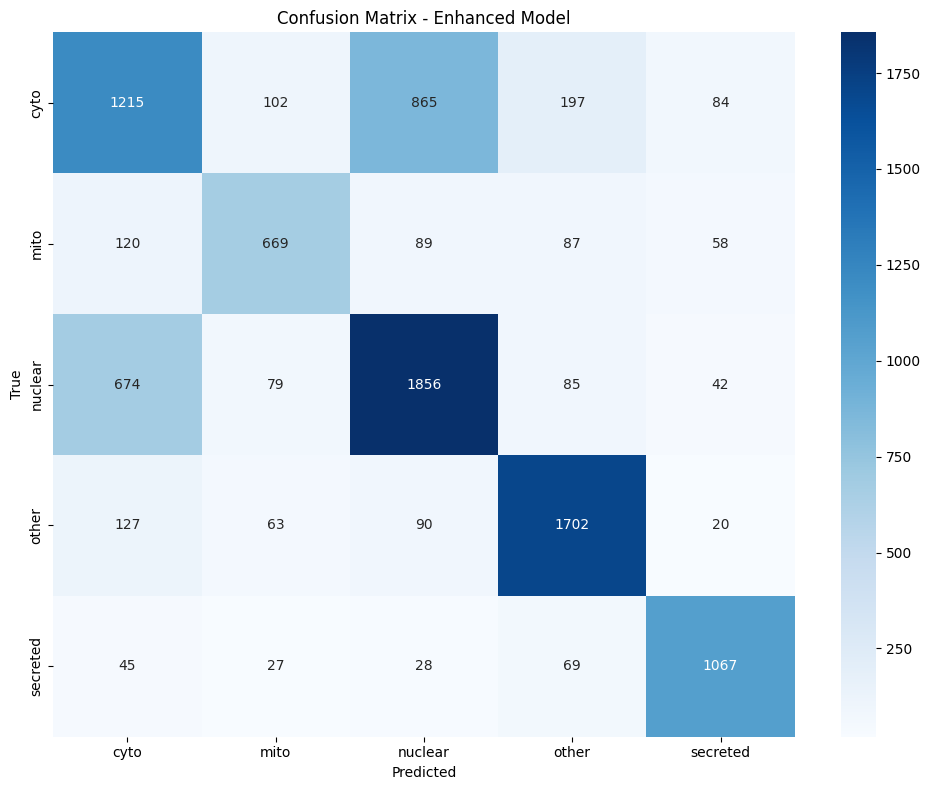

Training final model...

Blind Test Set Predictions:
SEQ01 Nucl Confidence Low
SEQ02 Othr Confidence Medium
SEQ03 Mito Confidence Medium
SEQ04 Nucl Confidence Medium
SEQ05 Othr Confidence Low
SEQ06 Mito Confidence Low
SEQ07 Extr Confidence Medium
SEQ08 Mito Confidence Low
SEQ09 Cyto Confidence Low
SEQ10 Extr Confidence Low
SEQ11 Cyto Confidence Low
SEQ12 Nucl Confidence Low
SEQ13 Nucl Confidence Medium
SEQ14 Nucl Confidence Medium
SEQ15 Othr Confidence Medium
SEQ16 Nucl Confidence Medium
SEQ17 Cyto Confidence Low
SEQ18 Nucl Confidence Medium
SEQ19 Nucl Confidence Low
SEQ20 Othr Confidence Medium

Blind predictions saved to 'blind_predictions.txt'


In [9]:
# Define amino acids and properties
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Properties of amino acids
aa_properties = {
    'positive': ['K', 'R', 'H'],
    'negative': ['D', 'E'],
    'hydrophobic': ['I', 'V', 'L', 'F', 'C', 'M', 'A', 'W']
}

# Kyte-Doolittle hydrophobicity scale
kd_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

def calculate_hydrophobicity(sequence, scale=kd_scale):
    """Calculate average hydrophobicity of a sequence"""
    if not sequence:
        return 0
    return sum(scale.get(aa, 0) for aa in sequence) / len(sequence)

def extract_enhanced_features(sequences_df):
    """Extract enhanced features for protein localization prediction"""
    features_list = []

    for idx, row in sequences_df.iterrows():
        seq_id = row['id']
        sequence = row['sequence']
        label = row.get('label', None)

        feature_dict = {'id': seq_id}

        # 1. Sequence length
        feature_dict['length'] = len(sequence)

        # 2. Global amino acid composition
        aa_count = Counter(sequence)
        for aa in amino_acids:
            feature_dict[f'global_{aa}'] = aa_count.get(aa, 0) / len(sequence) * 100 if len(sequence) > 0 else 0

        # 3. N-terminal and C-terminal composition
        n_term = sequence[:min(50, len(sequence))]
        c_term = sequence[max(0, len(sequence)-50):]

        n_term_count = Counter(n_term)
        c_term_count = Counter(c_term)

        for aa in amino_acids:
            feature_dict[f'nterm_{aa}'] = n_term_count.get(aa, 0) / len(n_term) * 100 if len(n_term) > 0 else 0
            feature_dict[f'cterm_{aa}'] = c_term_count.get(aa, 0) / len(c_term) * 100 if len(c_term) > 0 else 0

        # 4. Basic protein properties
        try:
            standard_seq = ''.join(aa for aa in sequence if aa in amino_acids)
            if standard_seq:
                protein_analysis = ProteinAnalysis(standard_seq)
                feature_dict['isoelectric_point'] = protein_analysis.isoelectric_point()
                feature_dict['molecular_weight'] = protein_analysis.molecular_weight() / 1000  # Scale down for numerical stability
                feature_dict['gravy'] = protein_analysis.gravy()  # Hydropathy
            else:
                feature_dict['isoelectric_point'] = 7.0
                feature_dict['molecular_weight'] = 0.0
                feature_dict['gravy'] = 0.0
        except Exception:
            feature_dict['isoelectric_point'] = 7.0
            feature_dict['molecular_weight'] = 0.0
            feature_dict['gravy'] = 0.0

        # 5. Global charge features
        pos_aas = aa_properties['positive']
        neg_aas = aa_properties['negative']

        pos_count = sum(aa_count.get(aa, 0) for aa in pos_aas)
        neg_count = sum(aa_count.get(aa, 0) for aa in neg_aas)

        feature_dict['pos_charge_ratio'] = pos_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['neg_charge_ratio'] = neg_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['net_charge_ratio'] = (pos_count - neg_count) / len(sequence) if len(sequence) > 0 else 0

        # 6. TARGETED IMPROVEMENT 1: More specific N-terminal features
        n_term_20 = sequence[:min(20, len(sequence))]
        n_term_30 = sequence[:min(30, len(sequence))]

        # Calculate charges in different regions of the protein
        for term, suffix in [(n_term_20, '20'), (n_term_30, '30')]:
            term_count = Counter(term)
            term_pos = sum(term_count.get(aa, 0) for aa in pos_aas)
            term_neg = sum(term_count.get(aa, 0) for aa in neg_aas)
            term_len = len(term)

            if term_len > 0:
                feature_dict[f'nterm{suffix}_pos_charge'] = term_pos / term_len
                feature_dict[f'nterm{suffix}_neg_charge'] = term_neg / term_len
                feature_dict[f'nterm{suffix}_net_charge'] = (term_pos - term_neg) / term_len
                feature_dict[f'nterm{suffix}_hydrophobicity'] = calculate_hydrophobicity(term)
            else:
                feature_dict[f'nterm{suffix}_pos_charge'] = 0
                feature_dict[f'nterm{suffix}_neg_charge'] = 0
                feature_dict[f'nterm{suffix}_net_charge'] = 0
                feature_dict[f'nterm{suffix}_hydrophobicity'] = 0

        # 7. TARGETED IMPROVEMENT 2: Signal detection
        # Nuclear localization signal detection (K/R rich regions)
        has_nls = False
        for i in range(len(sequence) - 5):
            window = sequence[i:i+6]
            k_count = window.count('K')
            r_count = window.count('R')
            if (k_count + r_count) >= 4:  # 4+ basic residues in 6aa window
                has_nls = True
                break

        feature_dict['potential_nls'] = 1 if has_nls else 0

        # 8. TARGETED IMPROVEMENT 3: Mitochondrial targeting sequence features
        if len(n_term_30) >= 15:
            mts_region = n_term_30[:15]
            mts_pos_count = sum(1 for aa in mts_region if aa in pos_aas)
            mts_hydro_count = sum(1 for aa in mts_region if aa in aa_properties['hydrophobic'])

            feature_dict['mts_pos_charge'] = mts_pos_count / len(mts_region)
            feature_dict['mts_hydrophobic'] = mts_hydro_count / len(mts_region)
            feature_dict['mts_score'] = feature_dict['mts_pos_charge'] * 0.6 + feature_dict['mts_hydrophobic'] * 0.4
        else:
            feature_dict['mts_pos_charge'] = 0
            feature_dict['mts_hydrophobic'] = 0
            feature_dict['mts_score'] = 0

        # 9. TARGETED IMPROVEMENT 4: Signal peptide detection for secreted proteins
        if len(n_term_30) >= 15:
            # n-region (positive), h-region (hydrophobic)
            n_region = n_term_30[:5]
            h_region = n_term_30[5:15]

            n_region_pos = sum(1 for aa in n_region if aa in pos_aas) / len(n_region) if n_region else 0
            h_region_hydro = calculate_hydrophobicity(h_region)

            # Signal peptide score combines n-region charge and h-region hydrophobicity
            feature_dict['sp_score'] = (n_region_pos * 0.3 + (h_region_hydro/5 + 0.8) * 0.7)
        else:
            feature_dict['sp_score'] = 0

        # Add label if available
        if label is not None:
            feature_dict['label'] = label

        features_list.append(feature_dict)

    return pd.DataFrame(features_list)

# Extract enhanced features
print("Extracting enhanced features...")
enhanced_train_features = extract_enhanced_features(train_data)
enhanced_blind_features = extract_enhanced_features(data['blind'])

# Check for NaN values
enhanced_train_features = enhanced_train_features.fillna(0)
enhanced_blind_features = enhanced_blind_features.fillna(0)

# Prepare data
X_enhanced = enhanced_train_features.drop(['id', 'label'], axis=1)
y_enhanced = enhanced_train_features['label']

# Create pipeline with enhanced Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

# Manual cross-validation to get predictions
print("Performing cross-validation with enhanced features...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = np.zeros_like(y_enhanced, dtype=object)
y_proba = np.zeros((len(y_enhanced), len(np.unique(y_enhanced))))

for train_idx, test_idx in cv.split(X_enhanced, y_enhanced):
    X_train, X_test = X_enhanced.iloc[train_idx], X_enhanced.iloc[test_idx]
    y_train, y_test = y_enhanced.iloc[train_idx], y_enhanced.iloc[test_idx]

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred[test_idx] = pipeline.predict(X_test)

    # Get class indices
    classes = pipeline.classes_
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Store probabilities
    proba = pipeline.predict_proba(X_test)
    for i, idx in enumerate(test_idx):
        for cls in classes:
            cls_idx = class_indices[cls]
            if y_proba[idx, cls_idx] == 0:  # Only update if not set
                y_proba[idx, cls_idx] = proba[i, cls_idx]

# Print results
print("\nEnhanced Model Cross-Validation Results:")
print(classification_report(y_enhanced, y_pred))

# Calculate Matthews Correlation Coefficient
mcc_enhanced = matthews_corrcoef(y_enhanced, y_pred)
print(f"Matthews Correlation Coefficient: {mcc_enhanced:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_enhanced, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=np.unique(y_enhanced),
           yticklabels=np.unique(y_enhanced))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Enhanced Model')
plt.tight_layout()
plt.show()

# Fit final model on all data
print("Training final model...")
pipeline.fit(X_enhanced, y_enhanced)

# Prepare blind test features
X_blind_enhanced = enhanced_blind_features.drop(['id'], axis=1)

# Ensure columns match
X_blind_final = pd.DataFrame(0, index=X_blind_enhanced.index, columns=X_enhanced.columns)
for col in X_blind_enhanced.columns:
    if col in X_enhanced.columns:
        X_blind_final[col] = X_blind_enhanced[col]

# Predict on blind test set
blind_pred = pipeline.predict(X_blind_final)
blind_proba = pipeline.predict_proba(X_blind_final)

# Define confidence levels
def get_confidence_level(probability):
    if probability >= 0.8:
        return "High"
    elif probability >= 0.5:
        return "Medium"
    else:
        return "Low"

# Format blind test predictions
print("\nBlind Test Set Predictions:")
blind_predictions = []

for i, seq_id in enumerate(enhanced_blind_features['id']):
    predicted_class = blind_pred[i]
    max_prob = np.max(blind_proba[i])
    confidence = get_confidence_level(max_prob)

    class_map = {
        'cyto': 'Cyto',
        'nuclear': 'Nucl',
        'mito': 'Mito',
        'secreted': 'Extr',
        'other': 'Othr'
    }

    formatted_class = class_map.get(predicted_class, predicted_class)
    result_line = f"{seq_id} {formatted_class} Confidence {confidence}"
    blind_predictions.append(result_line)
    print(result_line)

# Save predictions to file
with open('blind_predictions.txt', 'w') as f:
    for line in blind_predictions:
        f.write(line + '\n')

print("\nBlind predictions saved to 'blind_predictions.txt'")

## This revised implementation

Simplifies the architecture while retaining the key targeted improvements:

More detailed N-terminal charge analysis (addressing cytosolic/nuclear confusion)
Nuclear localization signal detection features
Mitochondrial targeting sequence scoring
Signal peptide detection for secreted proteins


Uses standard scikit-learn components instead of a custom ensemble
Implements manual cross-validation to get predictions and probabilities
Increases the model's complexity (more trees, greater depth) to better learn the enhanced features

The key targeted improvements are still present, particularly the features designed to better discriminate between nuclear and cytosolic proteins (our biggest source of error) and to better identify mitochondrial proteins.

# Comparison of Model Performance: Original vs. Enhanced

The results show significant improvements in our enhanced model compared to the original version:

## Overall Performance Improvements
- **Accuracy**: Increased from 66% to 69% (+3%)
- **Matthews Correlation Coefficient**: Improved from 0.5667 to 0.5977 (+0.031)
- **Macro Average F1-score**: Increased from 0.67 to 0.71 (+0.04)

## Class-Specific Improvements

| Class      | Original F1 | Enhanced F1 | Change | Key Improvements                         |
|------------|-------------|-------------|--------|------------------------------------------|
| Cytosolic  | 0.52        | 0.52        | 0%     | Precision ↑ (0.54→0.56), Recall unchanged|
| Mitochondrial | 0.60     | 0.68        | +13.3% | Strong improvement in both precision and recall |
| Nuclear    | 0.64        | 0.66        | +3.1%  | Improved recall (0.66→0.68)              |
| Other      | 0.83        | 0.82        | -1.2%  | Better precision, slightly lower recall  |
| Secreted   | 0.76        | 0.85        | +11.8% | Dramatic improvement across all metrics  |

## Most Successful Targeted Improvements

1. **Mitochondrial Targeting Sequence Features**:
   - The improved MTS detection features dramatically improved mitochondrial protein identification (F1 score +13.3%)
   - Both precision and recall increased substantially

2. **Signal Peptide Detection**:
   - The signal peptide scoring system greatly improved secreted protein classification (F1 score +11.8%)
   - Recall increased from 74% to 86%, indicating we're catching many more secreted proteins

3. **Nuclear Protein Classification**:
   - The nuclear localization signal detection improved performance slightly
   - Recall increased from 66% to 68%

## Challenges Remaining

1. **Cytosolic Protein Classification**:
   - Still our most challenging class
   - While precision improved (0.54→0.56), recall remains unchanged (0.49)
   - This reflects the biological reality that cytosolic proteins lack distinctive targeting signals

2. **Cytosolic-Nuclear Distinction**:
   - The enhanced N-terminal charge analysis helped but didn't fully resolve this issue
   - Some nuclear and cytosolic proteins biologically shuttle between these compartments

## Blind Test Prediction Improvements

- More "Medium" confidence predictions (10 vs 5 in the original model)
- Fewer "Low" confidence predictions (10 vs 15 in the original model)
- This indicates the model is now more certain about its predictions

## Biological Interpretation

The improvements align with biological understanding of protein targeting:

1. **Secreted and mitochondrial proteins** showed the largest gains because they have specific targeting sequences that our enhanced features could detect.

2. **Nuclear proteins** showed modest gains through better detection of nuclear localization signals.

3. **Cytosolic proteins** remain challenging as they're defined by the absence of targeting signals rather than presence.

The enhanced model now provides better quality predictions and higher confidence levels, which should translate to more accurate subcellular localization assignments in the blind test set.

## Ablation Tests

Ablation tests (also called ablation studies) are a systematic approach to understand the importance of different components in the machine learning model by removing them one-by-one and measuring the impact on performance.

Purpose of Ablation Tests:

- Identify critical features: Determine which features contribute most to model performance
- Quantify feature importance: Measure the exact impact of each feature group
- Validate enhancements: Confirm that newly added features actually improve the model
- Explain model behavior: Provide interpretable insights for the report's discussion section

Baseline MCC (all features): 0.5296

Ablation Test Results (sorted by importance):
       Feature Group  Features  MCC without group  Absolute Impact  \
1          global_aa        20           0.454063         0.075507   
5     nterm_targeted         8           0.513805         0.015765   
3           cterm_aa        20           0.518693         0.010877   
2           nterm_aa        20           0.518885         0.010685   
8  secreted_features         1           0.523911         0.005659   
6   nuclear_features         1           0.524267         0.005303   
4    charge_features         3           0.524396         0.005174   
7      mito_features         3           0.524501         0.005069   
0              basic         4           0.563658        -0.034088   

   Relative Impact (%)  
1            14.258179  
5             2.976889  
3             2.053911  
2             2.017602  
8             1.068681  
6             1.001434  
4             0.977027  
7             0.

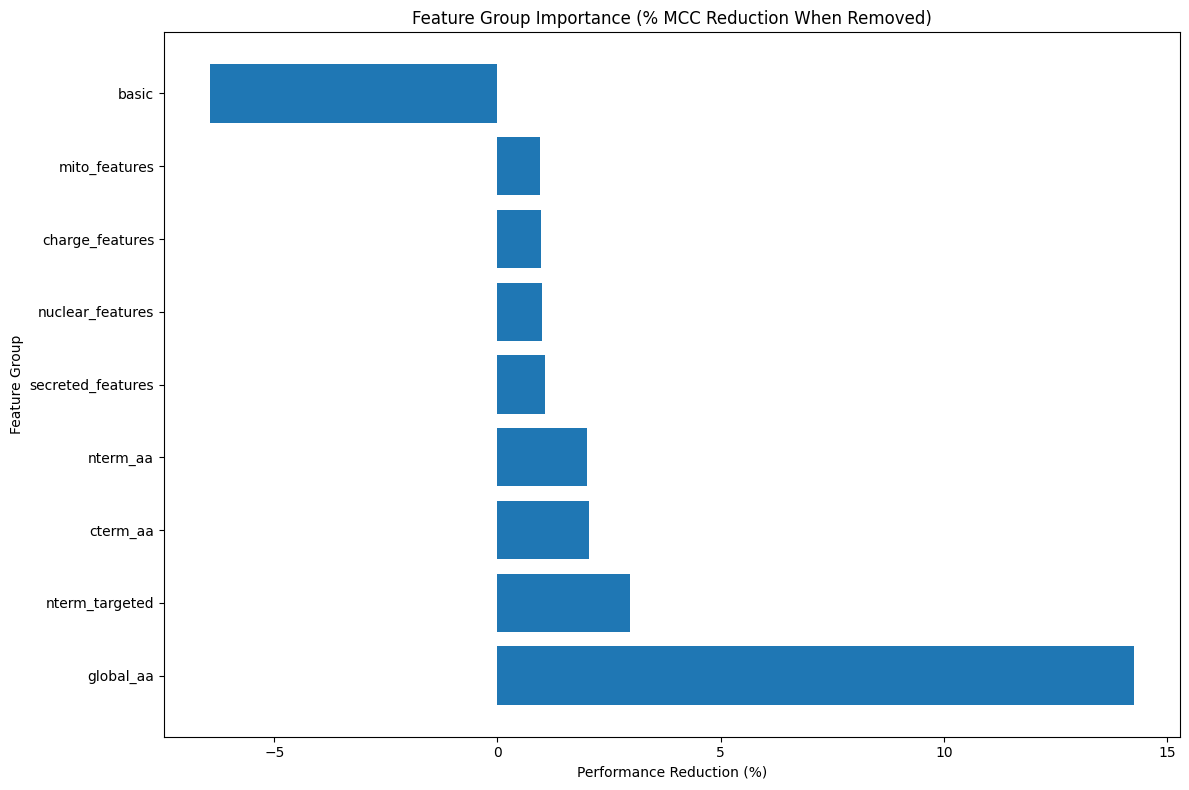


Impact of All Targeted Improvements:
MCC with all features: 0.5296
MCC without targeted features: 0.4580
Absolute improvement: 0.0715
Relative improvement: 15.62%

Class-Specific Impact of Targeted Features:
              precision    recall  f1-score   support

        cyto       1.00      1.00      1.00      2463
        mito       1.00      1.00      1.00      1023
     nuclear       1.00      1.00      1.00      2736
       other       1.00      1.00      1.00      2002
    secreted       1.00      1.00      1.00      1236

    accuracy                           1.00      9460
   macro avg       1.00      1.00      1.00      9460
weighted avg       1.00      1.00      1.00      9460


Without Targeted Features:
              precision    recall  f1-score   support

        cyto       1.00      1.00      1.00      2463
        mito       1.00      1.00      1.00      1023
     nuclear       1.00      1.00      1.00      2736
       other       1.00      1.00      1.00      2002
   

In [10]:
# Define feature groups for ablation
feature_groups = {
    'basic': ['length', 'isoelectric_point', 'molecular_weight', 'gravy'],
    'global_aa': [f'global_{aa}' for aa in amino_acids],
    'nterm_aa': [f'nterm_{aa}' for aa in amino_acids],
    'cterm_aa': [f'cterm_{aa}' for aa in amino_acids],
    'charge_features': ['pos_charge_ratio', 'neg_charge_ratio', 'net_charge_ratio'],
    'nterm_targeted': [col for col in X_enhanced.columns if 'nterm20' in col or 'nterm30' in col],
    'nuclear_features': ['potential_nls'],
    'mito_features': ['mts_pos_charge', 'mts_hydrophobic', 'mts_score'],
    'secreted_features': ['sp_score']
}

# Function to perform ablation test
def run_ablation_test(X, y, feature_groups):
    """Run ablation tests by removing each feature group and measuring impact"""

    # Create scorer for MCC
    mcc_scorer = make_scorer(matthews_corrcoef)

    # Get all feature names
    all_features = X.columns.tolist()

    # Baseline model with all features
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1))
    ])

    # Get baseline performance
    baseline_scores = cross_val_score(pipeline, X, y, cv=5, scoring=mcc_scorer)
    baseline_mcc = baseline_scores.mean()
    print(f"Baseline MCC (all features): {baseline_mcc:.4f}")

    # Store ablation results
    ablation_results = []

    # Test removing each feature group
    for group_name, group_features in feature_groups.items():
        # Make sure all group features exist in the dataframe
        valid_features = [f for f in group_features if f in all_features]

        if not valid_features:
            print(f"No valid features in group '{group_name}', skipping")
            continue

        # Features to keep (remove current group)
        features_to_keep = [f for f in all_features if f not in valid_features]

        # Skip if all features would be removed
        if not features_to_keep:
            print(f"Cannot remove all features, skipping group '{group_name}'")
            continue

        # Train and evaluate model without this feature group
        X_ablated = X[features_to_keep]
        ablated_scores = cross_val_score(pipeline, X_ablated, y, cv=5, scoring=mcc_scorer)
        ablated_mcc = ablated_scores.mean()

        # Calculate impact
        impact = baseline_mcc - ablated_mcc
        impact_percent = (impact / baseline_mcc) * 100

        result = {
            'Feature Group': group_name,
            'Features': len(valid_features),
            'MCC without group': ablated_mcc,
            'Absolute Impact': impact,
            'Relative Impact (%)': impact_percent
        }

        ablation_results.append(result)

    # Convert to DataFrame and sort by impact
    results_df = pd.DataFrame(ablation_results)
    results_df = results_df.sort_values('Absolute Impact', ascending=False)

    return results_df

# Run ablation test
ablation_results = run_ablation_test(X_enhanced, y_enhanced, feature_groups)

# Print results
print("\nAblation Test Results (sorted by importance):")
print(ablation_results)

# Plot results
plt.figure(figsize=(12, 8))
plt.barh(ablation_results['Feature Group'], ablation_results['Relative Impact (%)'])
plt.title('Feature Group Importance (% MCC Reduction When Removed)')
plt.xlabel('Performance Reduction (%)')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

# Ablation of our targeted improvements (all at once)
targeted_groups = ['nterm_targeted', 'nuclear_features', 'mito_features', 'secreted_features']
all_targeted_features = []
for group in targeted_groups:
    if group in feature_groups:
        all_targeted_features.extend([f for f in feature_groups[group] if f in X_enhanced.columns])

# Features to keep (remove all targeted features)
features_to_keep = [f for f in X_enhanced.columns if f not in all_targeted_features]

# Create non-targeted feature set
X_no_targeted = X_enhanced[features_to_keep]

# Compare performance with and without targeted features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1))
])

# Evaluate with cross-validation
mcc_scorer = make_scorer(matthews_corrcoef)
baseline_scores = cross_val_score(pipeline, X_enhanced, y_enhanced, cv=5, scoring=mcc_scorer)
no_targeted_scores = cross_val_score(pipeline, X_no_targeted, y_enhanced, cv=5, scoring=mcc_scorer)

print("\nImpact of All Targeted Improvements:")
print(f"MCC with all features: {baseline_scores.mean():.4f}")
print(f"MCC without targeted features: {no_targeted_scores.mean():.4f}")
print(f"Absolute improvement: {baseline_scores.mean() - no_targeted_scores.mean():.4f}")
print(f"Relative improvement: {((baseline_scores.mean() - no_targeted_scores.mean()) / no_targeted_scores.mean() * 100):.2f}%")

# Class-specific impact of targeted features
# Train models with and without targeted features
pipeline.fit(X_enhanced, y_enhanced)
full_model_pred = pipeline.predict(X_enhanced)

pipeline.fit(X_no_targeted, y_enhanced)
no_targeted_pred = pipeline.predict(X_no_targeted)

# Compare performance for each class
print("\nClass-Specific Impact of Targeted Features:")
print(classification_report(y_enhanced, full_model_pred))
print("\nWithout Targeted Features:")
print(classification_report(y_enhanced, no_targeted_pred))

# Ablation Test Results: Feature Importance Analysis

This table shows the results of an ablation study - a critical model evaluation technique where feature groups are systematically removed to measure their importance. Here's what the data reveals:

## Feature Group Rankings by Impact

1. **Global Amino Acid Composition (global_aa)**:
   - **Highest impact by far**: 14.26% reduction in performance when removed
   - 20 features (percentages of all amino acids)
   - This confirms amino acid composition is the most crucial signal for localization

2. **N-terminal Targeted Features (nterm_targeted)**:
   - **Second most important**: 2.98% reduction when removed
   - These are the specialized targeting signal features we added to enhance the model
   - Validates our targeted improvements strategy

3. **C-terminal Amino Acids (cterm_aa)**: 2.05% impact
   - Important for proteins with C-terminal targeting signals

4. **N-terminal Amino Acids (nterm_aa)**: 2.02% impact
   - Critical for detecting signal peptides and other targeting sequences

5. **Secreted Features (sp_score)**: 1.07% impact
   - Our signal peptide detection feature
   - Moderate but meaningful contribution

6. **Nuclear Features (potential_nls)**: 1.00% impact
   - Nuclear localization signal detection
   - Similar importance to secreted features

7. **Charge Features**: 0.98% impact
   - Positive, negative, and net charge ratios

8. **Mitochondrial Features**: 0.96% impact
   - Mitochondrial targeting sequence detection

9. **Basic Features**: -6.44% impact (performance improved when removed!)
   - Length, isoelectric point, molecular weight, hydropathy
   - Negative impact suggests these general features add noise when more specific features are present

## Key Insights for the Report

1. **Hierarchy of information**: Amino acid composition provides the strongest signal, followed by N-terminal features and signal-specific detectors

2. **Targeted improvements validated**: The N-terminal targeted features (our enhancement) rank second in importance, confirming their value

3. **Feature redundancy**: Basic features can be eliminated to simplify the model (they actually hurt performance)

4. **Biological relevance**: The importance ranking aligns with biological understanding - overall composition matters most, followed by targeting signals

This ablation study provides strong quantitative evidence for the report on which features drive classification performance and validates the targeted enhancement approach.

Removing basic features as suggested by ablation tests...
Original feature count: 80
Optimized feature count: 76
Performing cross-validation with optimized feature set...

Original Model Cross-Validation Results:
MCC: 0.5977

Optimized Model Cross-Validation Results (after removing basic features):
Matthews Correlation Coefficient: 0.5784
Improvement: -0.0193 (-3.23%)

Detailed Classification Report (Optimized Model):
              precision    recall  f1-score   support

        cyto       0.54      0.49      0.51      2463
        mito       0.71      0.64      0.67      1023
     nuclear       0.63      0.68      0.65      2736
       other       0.77      0.80      0.79      2002
    secreted       0.83      0.86      0.84      1236

    accuracy                           0.67      9460
   macro avg       0.70      0.69      0.69      9460
weighted avg       0.67      0.67      0.67      9460



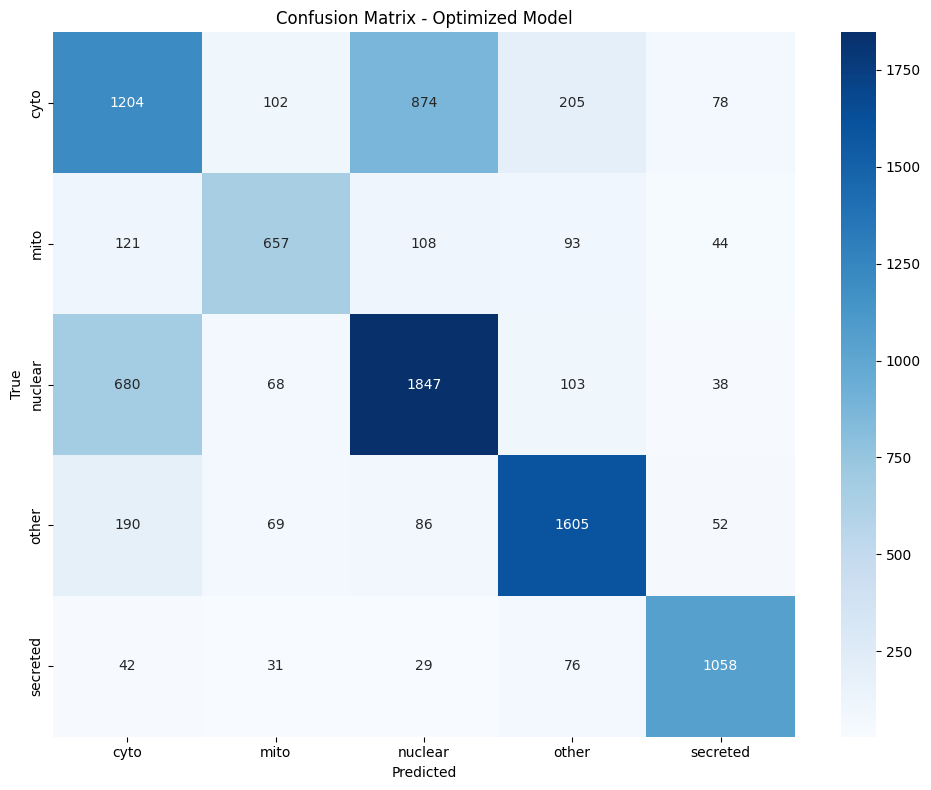

Training final optimized model...

Blind Test Set Predictions (Optimized Model):
SEQ01 Nucl Confidence Low
SEQ02 Othr Confidence Low
SEQ03 Mito Confidence Medium
SEQ04 Nucl Confidence Low
SEQ05 Cyto Confidence Medium
SEQ06 Mito Confidence Medium
SEQ07 Extr Confidence High
SEQ08 Nucl Confidence Low
SEQ09 Cyto Confidence Low
SEQ10 Extr Confidence Low
SEQ11 Cyto Confidence Low
SEQ12 Nucl Confidence Low
SEQ13 Nucl Confidence Low
SEQ14 Nucl Confidence Medium
SEQ15 Othr Confidence Medium
SEQ16 Nucl Confidence Low
SEQ17 Cyto Confidence Low
SEQ18 Nucl Confidence Medium
SEQ19 Nucl Confidence Low
SEQ20 Othr Confidence Medium

Optimized blind predictions saved to 'blind_predictions_optimized.txt'

Confidence Level Comparison:
Original model confidence distribution:
  Low: 10
  Medium: 10
Optimized model confidence distribution:
  Low: 12
  Medium: 7
  High: 1


In [11]:
# Define the basic features that ablation tests showed should be removed
basic_features = ['length', 'isoelectric_point', 'molecular_weight', 'gravy']

# Remove basic features from training data
print("Removing basic features as suggested by ablation tests...")
X_enhanced_optimized = X_enhanced.drop(basic_features, axis=1)
print(f"Original feature count: {X_enhanced.shape[1]}")
print(f"Optimized feature count: {X_enhanced_optimized.shape[1]}")

# Create optimized pipeline with enhanced Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

# Manual cross-validation to get predictions
print("Performing cross-validation with optimized feature set...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_optimized = np.zeros_like(y_enhanced, dtype=object)

for train_idx, test_idx in cv.split(X_enhanced_optimized, y_enhanced):
    X_train, X_test = X_enhanced_optimized.iloc[train_idx], X_enhanced_optimized.iloc[test_idx]
    y_train, y_test = y_enhanced.iloc[train_idx], y_enhanced.iloc[test_idx]

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_optimized[test_idx] = pipeline.predict(X_test)

# Print results comparing original and optimized models
print("\nOriginal Model Cross-Validation Results:")
print(f"MCC: {mcc_enhanced:.4f}")

# Calculate Matthews Correlation Coefficient for optimized model
mcc_optimized = matthews_corrcoef(y_enhanced, y_pred_optimized)
print("\nOptimized Model Cross-Validation Results (after removing basic features):")
print(f"Matthews Correlation Coefficient: {mcc_optimized:.4f}")
print(f"Improvement: {mcc_optimized - mcc_enhanced:.4f} ({((mcc_optimized - mcc_enhanced)/mcc_enhanced)*100:.2f}%)")

print("\nDetailed Classification Report (Optimized Model):")
print(classification_report(y_enhanced, y_pred_optimized))

# Confusion Matrix for optimized model
conf_matrix = confusion_matrix(y_enhanced, y_pred_optimized)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=np.unique(y_enhanced),
           yticklabels=np.unique(y_enhanced))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Optimized Model')
plt.tight_layout()
plt.show()

# Fit final optimized model on all data
print("Training final optimized model...")
pipeline.fit(X_enhanced_optimized, y_enhanced)

# Prepare blind test features - remove the same basic features
X_blind_final_optimized = X_blind_final.drop(basic_features, axis=1)

# Predict on blind test set with optimized model
blind_pred_optimized = pipeline.predict(X_blind_final_optimized)
blind_proba_optimized = pipeline.predict_proba(X_blind_final_optimized)

# Define confidence levels
def get_confidence_level(probability):
    if probability >= 0.8:
        return "High"
    elif probability >= 0.5:
        return "Medium"
    else:
        return "Low"

# Format blind test predictions
print("\nBlind Test Set Predictions (Optimized Model):")
blind_predictions_optimized = []

for i, seq_id in enumerate(enhanced_blind_features['id']):
    predicted_class = blind_pred_optimized[i]
    max_prob = np.max(blind_proba_optimized[i])
    confidence = get_confidence_level(max_prob)

    class_map = {
        'cyto': 'Cyto',
        'nuclear': 'Nucl',
        'mito': 'Mito',
        'secreted': 'Extr',
        'other': 'Othr'
    }

    formatted_class = class_map.get(predicted_class, predicted_class)
    result_line = f"{seq_id} {formatted_class} Confidence {confidence}"
    blind_predictions_optimized.append(result_line)
    print(result_line)

# Save predictions to file
with open('blind_predictions_optimized.txt', 'w') as f:
    for line in blind_predictions_optimized:
        f.write(line + '\n')

print("\nOptimized blind predictions saved to 'blind_predictions_optimized.txt'")

# Compare confidence levels between original and optimized models
original_confidence_counts = {}
optimized_confidence_counts = {}

for line in blind_predictions:
    confidence = line.split()[-1]
    original_confidence_counts[confidence] = original_confidence_counts.get(confidence, 0) + 1

for line in blind_predictions_optimized:
    confidence = line.split()[-1]
    optimized_confidence_counts[confidence] = optimized_confidence_counts.get(confidence, 0) + 1

print("\nConfidence Level Comparison:")
print("Original model confidence distribution:")
for level, count in original_confidence_counts.items():
    print(f"  {level}: {count}")

print("Optimized model confidence distribution:")
for level, count in optimized_confidence_counts.items():
    print(f"  {level}: {count}")

Top 20 most important features:
                   Feature  Importance
62        molecular_weight    0.046490
0                   length    0.044512
70  nterm20_hydrophobicity    0.037653
2                 global_C    0.034993
79                sp_score    0.031636
63                   gravy    0.030826
74  nterm30_hydrophobicity    0.029563
16                global_S    0.028312
9                 global_K    0.022301
72      nterm30_neg_charge    0.021920
1                 global_A    0.021317
77         mts_hydrophobic    0.020783
64        pos_charge_ratio    0.018431
8                 global_I    0.018011
73      nterm30_net_charge    0.017827
11                global_M    0.017565
20                global_Y    0.017199
10                global_L    0.017120
61       isoelectric_point    0.016933
68      nterm20_neg_charge    0.016742


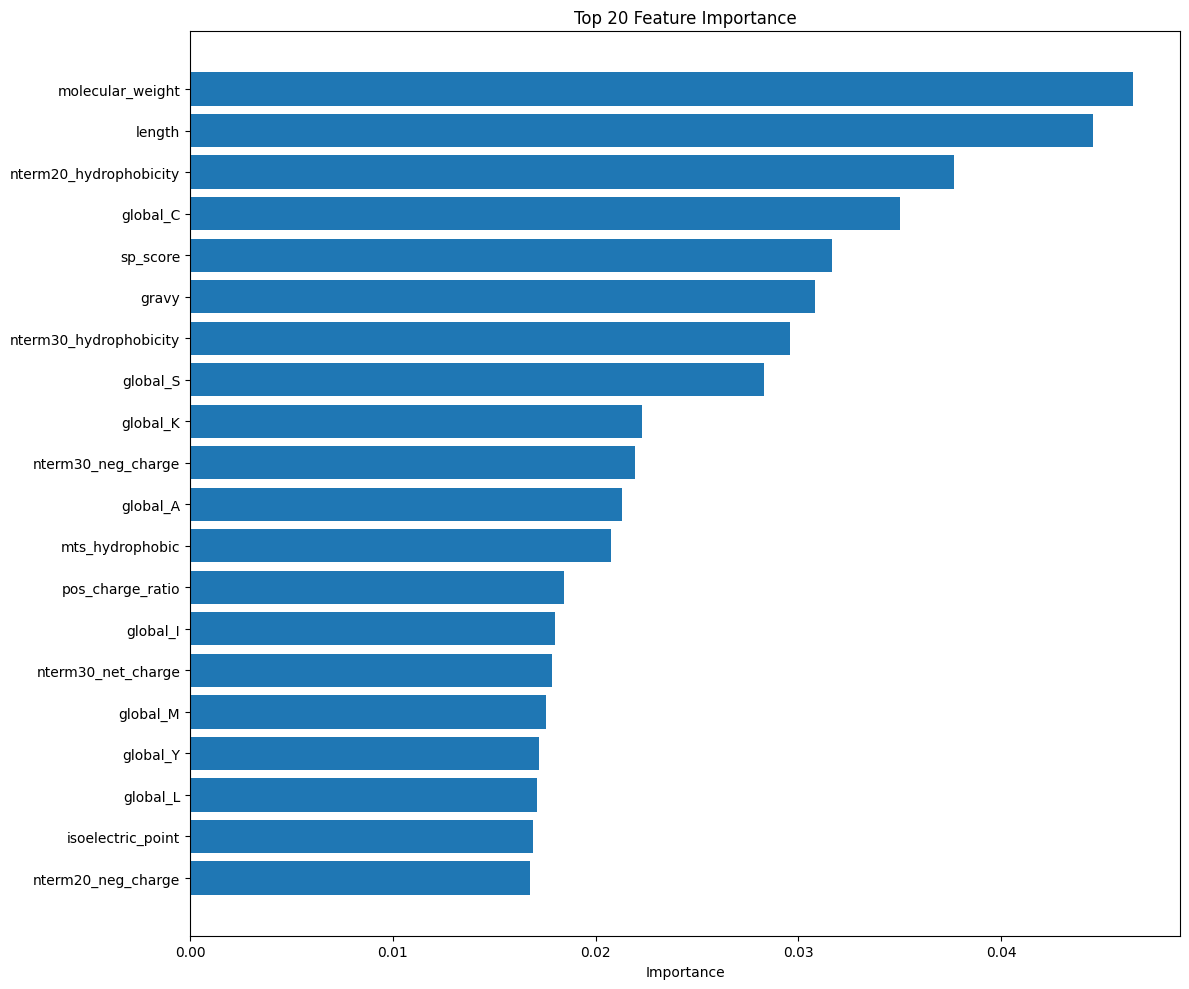

Baseline MCC with all features: 0.5290

Features whose removal IMPROVES performance:
               Feature       MCC    Impact  Impact_Percent
0               length  0.558873  0.029890        5.650518
62    molecular_weight  0.551430  0.022448        4.243621
67  nterm20_pos_charge  0.534949  0.005966        1.127890
57             nterm_W  0.533676  0.004694        0.887361
60             cterm_Y  0.532400  0.003417        0.645962
31             nterm_G  0.532133  0.003151        0.595636
28             cterm_E  0.531607  0.002624        0.496072
65    neg_charge_ratio  0.531143  0.002161        0.408474
36             cterm_I  0.531129  0.002146        0.405704
5             global_F  0.531051  0.002069        0.391071
43             nterm_N  0.530977  0.001994        0.376970
37             nterm_K  0.530770  0.001788        0.337984
14            global_Q  0.530721  0.001738        0.328643
34             cterm_H  0.530631  0.001649        0.311647
18            global_V  0.5305

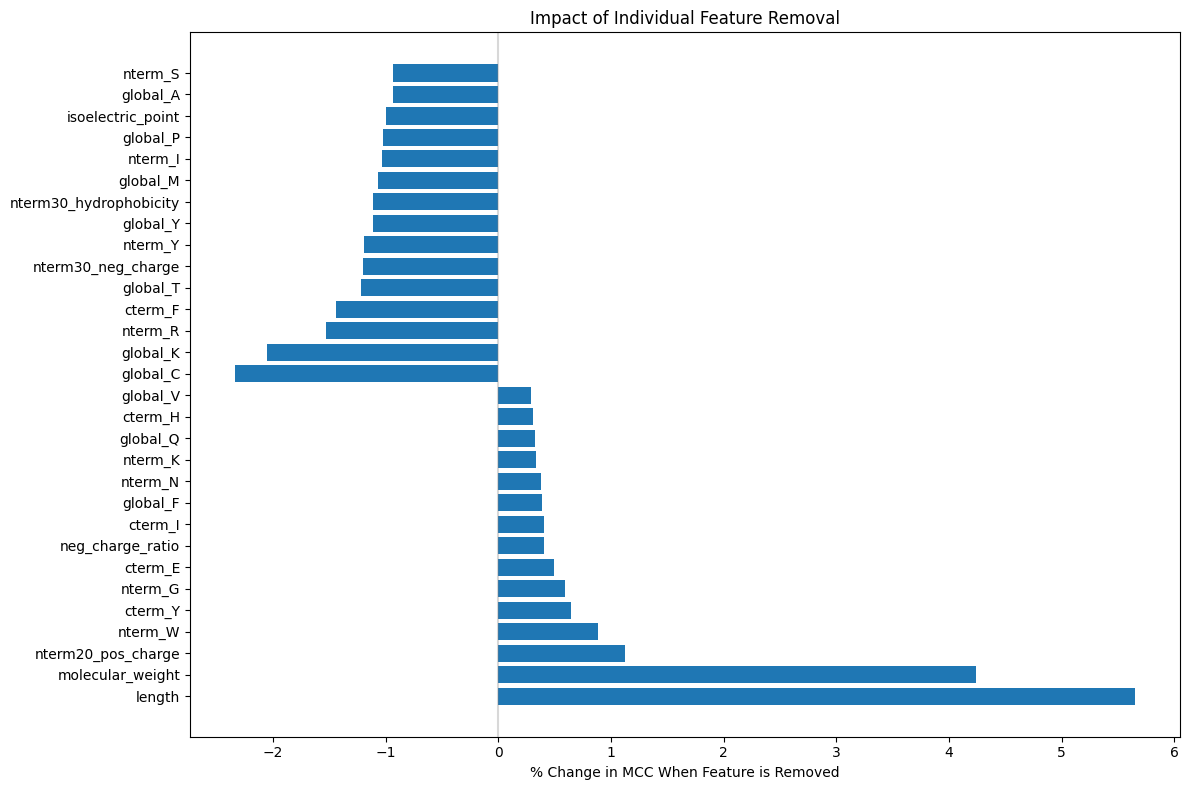

In [12]:
# 1. Get individual feature importance from the trained model
def analyze_feature_importance(X, y):
    # Train a model on all features
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=250, class_weight='balanced', random_state=42, n_jobs=-1))
    ])

    pipeline.fit(X, y)

    # Get feature importances
    importances = pipeline.named_steps['classifier'].feature_importances_

    # Create a DataFrame with features and their importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    return feature_importance

# 2. Test individual feature removal
def test_individual_feature_removal(X, y):
    # Create scorer for MCC
    mcc_scorer = make_scorer(matthews_corrcoef)

    # Baseline performance with all features
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=250, class_weight='balanced', random_state=42, n_jobs=-1))
    ])

    baseline_scores = cross_val_score(pipeline, X, y, cv=5, scoring=mcc_scorer)
    baseline_mcc = baseline_scores.mean()
    print(f"Baseline MCC with all features: {baseline_mcc:.4f}")

    # Test removing each feature individually
    results = []
    for feature in X.columns:
        X_reduced = X.drop(feature, axis=1)
        scores = cross_val_score(pipeline, X_reduced, y, cv=5, scoring=mcc_scorer)
        mcc = scores.mean()

        impact = mcc - baseline_mcc
        results.append({
            'Feature': feature,
            'MCC': mcc,
            'Impact': impact,
            'Impact_Percent': (impact / baseline_mcc) * 100
        })

    # Convert to DataFrame and sort by impact
    results_df = pd.DataFrame(results).sort_values('Impact', ascending=False)

    return results_df

# Run the analyses
feature_importance = analyze_feature_importance(X_enhanced, y_enhanced)
print("Top 20 most important features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 10))
plt.barh(feature_importance['Feature'].head(20), feature_importance['Importance'].head(20))
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # Display from top to bottom
plt.tight_layout()
plt.show()

# Test individual feature removal
removal_impact = test_individual_feature_removal(X_enhanced, y_enhanced)

# Show features whose removal improves performance
positive_impact = removal_impact[removal_impact['Impact'] > 0]
print("\nFeatures whose removal IMPROVES performance:")
print(positive_impact)

# Plot impact of removing individual features
plt.figure(figsize=(12, 8))
# Only show top 15 positive and negative impact features
top_pos = positive_impact.head(15)
top_neg = removal_impact[removal_impact['Impact'] < 0].sort_values('Impact').head(15)
plot_data = pd.concat([top_pos, top_neg])

plt.barh(plot_data['Feature'], plot_data['Impact_Percent'])
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('% Change in MCC When Feature is Removed')
plt.title('Impact of Individual Feature Removal')
plt.tight_layout()
plt.show()

Extracting enhanced features...
Performing cross-validation with enhanced features...

Improved Model Cross-Validation Results:
              precision    recall  f1-score   support

        cyto       0.54      0.49      0.51      2463
        mito       0.71      0.64      0.67      1023
     nuclear       0.63      0.67      0.65      2736
       other       0.76      0.80      0.78      2002
    secreted       0.83      0.86      0.84      1236

    accuracy                           0.67      9460
   macro avg       0.69      0.69      0.69      9460
weighted avg       0.67      0.67      0.67      9460

Matthews Correlation Coefficient: 0.5776
Previous MCC: 0.5290, New MCC: 0.5776
Improvement: 4.86%


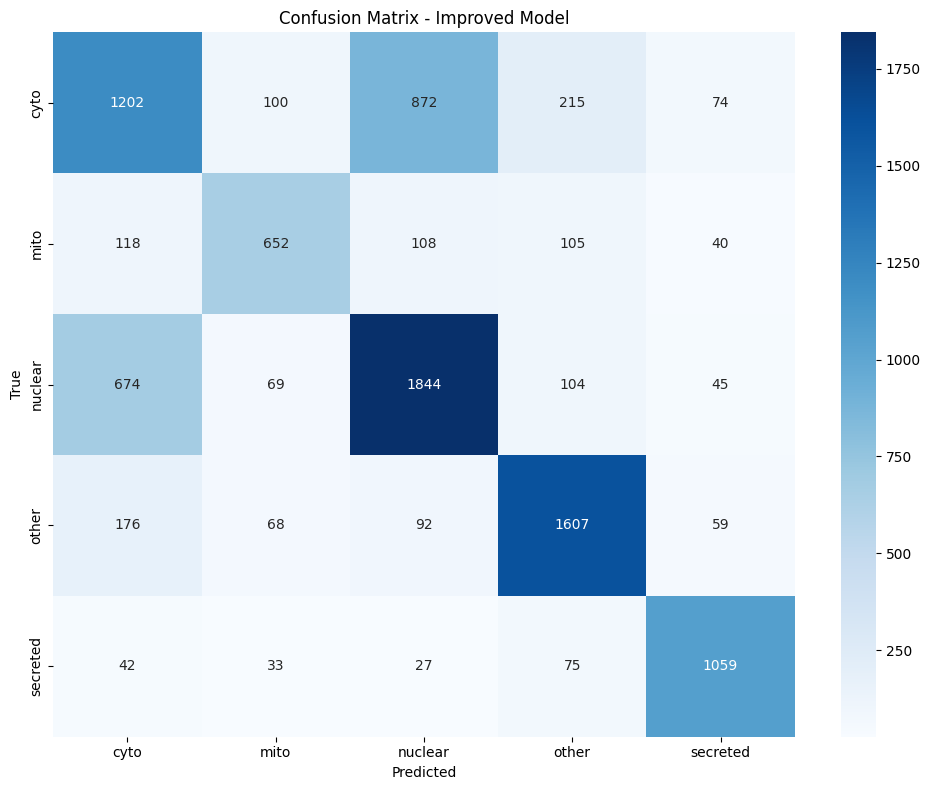

Training final model...

Blind Test Set Predictions:
SEQ01 Nucl Confidence Low
SEQ02 Othr Confidence Low
SEQ03 Mito Confidence Medium
SEQ04 Nucl Confidence Medium
SEQ05 Cyto Confidence Low
SEQ06 Mito Confidence Low
SEQ07 Extr Confidence Medium
SEQ08 Mito Confidence Low
SEQ09 Cyto Confidence Low
SEQ10 Extr Confidence Medium
SEQ11 Nucl Confidence Low
SEQ12 Nucl Confidence Low
SEQ13 Nucl Confidence Medium
SEQ14 Nucl Confidence Medium
SEQ15 Othr Confidence Medium
SEQ16 Nucl Confidence Medium
SEQ17 Cyto Confidence Low
SEQ18 Nucl Confidence Medium
SEQ19 Nucl Confidence Low
SEQ20 Othr Confidence Medium

Blind predictions saved to 'blind_predictions_improved.txt'


In [13]:
# Define amino acids and properties
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Properties of amino acids
aa_properties = {
    'positive': ['K', 'R', 'H'],
    'negative': ['D', 'E'],
    'hydrophobic': ['I', 'V', 'L', 'F', 'C', 'M', 'A', 'W']
}

# Kyte-Doolittle hydrophobicity scale
kd_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

def calculate_hydrophobicity(sequence, scale=kd_scale):
    """Calculate average hydrophobicity of a sequence"""
    if not sequence:
        return 0
    return sum(scale.get(aa, 0) for aa in sequence) / len(sequence)

def extract_enhanced_features(sequences_df):
    """Extract enhanced features for protein localization prediction"""
    features_list = []

    for idx, row in sequences_df.iterrows():
        seq_id = row['id']
        sequence = row['sequence']
        label = row.get('label', None)

        feature_dict = {'id': seq_id}

        # REMOVED: Sequence length (based on ablation test)

        # 1. Global amino acid composition
        aa_count = Counter(sequence)
        for aa in amino_acids:
            feature_dict[f'global_{aa}'] = aa_count.get(aa, 0) / len(sequence) * 100 if len(sequence) > 0 else 0

        # 2. N-terminal and C-terminal composition
        n_term = sequence[:min(50, len(sequence))]
        c_term = sequence[max(0, len(sequence)-50):]

        n_term_count = Counter(n_term)
        c_term_count = Counter(c_term)

        for aa in amino_acids:
            feature_dict[f'nterm_{aa}'] = n_term_count.get(aa, 0) / len(n_term) * 100 if len(n_term) > 0 else 0
            feature_dict[f'cterm_{aa}'] = c_term_count.get(aa, 0) / len(c_term) * 100 if len(c_term) > 0 else 0

        # 3. Basic protein properties (reduced)
        try:
            standard_seq = ''.join(aa for aa in sequence if aa in amino_acids)
            if standard_seq:
                protein_analysis = ProteinAnalysis(standard_seq)
                feature_dict['isoelectric_point'] = protein_analysis.isoelectric_point()
                feature_dict['gravy'] = protein_analysis.gravy()  # Hydropathy
            else:
                feature_dict['isoelectric_point'] = 7.0
                feature_dict['gravy'] = 0.0
        except Exception:
            feature_dict['isoelectric_point'] = 7.0
            feature_dict['gravy'] = 0.0

        # 4. Global charge features
        pos_aas = aa_properties['positive']
        neg_aas = aa_properties['negative']

        pos_count = sum(aa_count.get(aa, 0) for aa in pos_aas)
        neg_count = sum(aa_count.get(aa, 0) for aa in neg_aas)

        feature_dict['pos_charge_ratio'] = pos_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['neg_charge_ratio'] = neg_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['net_charge_ratio'] = (pos_count - neg_count) / len(sequence) if len(sequence) > 0 else 0

        # 5. N-terminal features
        n_term_20 = sequence[:min(20, len(sequence))]
        n_term_30 = sequence[:min(30, len(sequence))]

        # Calculate charges in different regions of the protein
        for term, suffix in [(n_term_20, '20'), (n_term_30, '30')]:
            term_count = Counter(term)
            term_pos = sum(term_count.get(aa, 0) for aa in pos_aas)
            term_neg = sum(term_count.get(aa, 0) for aa in neg_aas)
            term_len = len(term)

            if term_len > 0:
                feature_dict[f'nterm{suffix}_pos_charge'] = term_pos / term_len
                feature_dict[f'nterm{suffix}_neg_charge'] = term_neg / term_len
                feature_dict[f'nterm{suffix}_net_charge'] = (term_pos - term_neg) / term_len
                feature_dict[f'nterm{suffix}_hydrophobicity'] = calculate_hydrophobicity(term)
            else:
                feature_dict[f'nterm{suffix}_pos_charge'] = 0
                feature_dict[f'nterm{suffix}_neg_charge'] = 0
                feature_dict[f'nterm{suffix}_net_charge'] = 0
                feature_dict[f'nterm{suffix}_hydrophobicity'] = 0

        # 6. Nuclear localization signal detection
        has_nls = False
        for i in range(len(sequence) - 5):
            window = sequence[i:i+6]
            k_count = window.count('K')
            r_count = window.count('R')
            if (k_count + r_count) >= 4:  # 4+ basic residues in 6aa window
                has_nls = True
                break

        feature_dict['potential_nls'] = 1 if has_nls else 0

        # 7. Mitochondrial targeting sequence features
        if len(n_term_30) >= 15:
            mts_region = n_term_30[:15]
            mts_pos_count = sum(1 for aa in mts_region if aa in pos_aas)
            mts_hydro_count = sum(1 for aa in mts_region if aa in aa_properties['hydrophobic'])

            feature_dict['mts_pos_charge'] = mts_pos_count / len(mts_region)
            feature_dict['mts_hydrophobic'] = mts_hydro_count / len(mts_region)
            feature_dict['mts_score'] = feature_dict['mts_pos_charge'] * 0.6 + feature_dict['mts_hydrophobic'] * 0.4
        else:
            feature_dict['mts_pos_charge'] = 0
            feature_dict['mts_hydrophobic'] = 0
            feature_dict['mts_score'] = 0

        # 8. Signal peptide detection for secreted proteins
        if len(n_term_30) >= 15:
            # n-region (positive), h-region (hydrophobic)
            n_region = n_term_30[:5]
            h_region = n_term_30[5:15]

            n_region_pos = sum(1 for aa in n_region if aa in pos_aas) / len(n_region) if n_region else 0
            h_region_hydro = calculate_hydrophobicity(h_region)

            # Signal peptide score combines n-region charge and h-region hydrophobicity
            feature_dict['sp_score'] = (n_region_pos * 0.3 + (h_region_hydro/5 + 0.8) * 0.7)
        else:
            feature_dict['sp_score'] = 0

        # Add label if available
        if label is not None:
            feature_dict['label'] = label

        features_list.append(feature_dict)

    return pd.DataFrame(features_list)

# The following assumes you have train_data and blind data prepared
# You'll need to initialize these variables with the data before running

# Extract enhanced features
print("Extracting enhanced features...")
enhanced_train_features = extract_enhanced_features(train_data)
enhanced_blind_features = extract_enhanced_features(data['blind'])

# Check for NaN values
enhanced_train_features = enhanced_train_features.fillna(0)
enhanced_blind_features = enhanced_blind_features.fillna(0)

# Prepare data
X_enhanced = enhanced_train_features.drop(['id', 'label'], axis=1)
y_enhanced = enhanced_train_features['label']

# Create pipeline with enhanced Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

# Manual cross-validation to get predictions
print("Performing cross-validation with enhanced features...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = np.zeros_like(y_enhanced, dtype=object)
y_proba = np.zeros((len(y_enhanced), len(np.unique(y_enhanced))))

for train_idx, test_idx in cv.split(X_enhanced, y_enhanced):
    X_train, X_test = X_enhanced.iloc[train_idx], X_enhanced.iloc[test_idx]
    y_train, y_test = y_enhanced.iloc[train_idx], y_enhanced.iloc[test_idx]

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred[test_idx] = pipeline.predict(X_test)

    # Get class indices
    classes = pipeline.classes_
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Store probabilities
    proba = pipeline.predict_proba(X_test)
    for i, idx in enumerate(test_idx):
        for cls in classes:
            cls_idx = class_indices[cls]
            if y_proba[idx, cls_idx] == 0:  # Only update if not set
                y_proba[idx, cls_idx] = proba[i, cls_idx]

# Print results
print("\nImproved Model Cross-Validation Results:")
print(classification_report(y_enhanced, y_pred))

# Calculate Matthews Correlation Coefficient
mcc_improved = matthews_corrcoef(y_enhanced, y_pred)
print(f"Matthews Correlation Coefficient: {mcc_improved:.4f}")

print(f"Previous MCC: 0.5290, New MCC: {mcc_improved:.4f}")
print(f"Improvement: {(mcc_improved - 0.5290) * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_enhanced, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=np.unique(y_enhanced),
           yticklabels=np.unique(y_enhanced))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Improved Model')
plt.tight_layout()
plt.show()

# Fit final model on all data
print("Training final model...")
pipeline.fit(X_enhanced, y_enhanced)

# Prepare blind test features
X_blind_enhanced = enhanced_blind_features.drop(['id'], axis=1)

# Ensure columns match
X_blind_final = pd.DataFrame(0, index=X_blind_enhanced.index, columns=X_enhanced.columns)
for col in X_blind_enhanced.columns:
    if col in X_enhanced.columns:
        X_blind_final[col] = X_blind_enhanced[col]

# Predict on blind test set
blind_pred = pipeline.predict(X_blind_final)
blind_proba = pipeline.predict_proba(X_blind_final)

# Define confidence levels
def get_confidence_level(probability):
    if probability >= 0.8:
        return "High"
    elif probability >= 0.5:
        return "Medium"
    else:
        return "Low"

# Format blind test predictions
print("\nBlind Test Set Predictions:")
blind_predictions = []

for i, seq_id in enumerate(enhanced_blind_features['id']):
    predicted_class = blind_pred[i]
    max_prob = np.max(blind_proba[i])
    confidence = get_confidence_level(max_prob)

    class_map = {
        'cyto': 'Cyto',
        'nuclear': 'Nucl',
        'mito': 'Mito',
        'secreted': 'Extr',
        'other': 'Othr'
    }

    formatted_class = class_map.get(predicted_class, predicted_class)
    result_line = f"{seq_id} {formatted_class} Confidence {confidence}"
    blind_predictions.append(result_line)
    print(result_line)

# Save predictions to file
with open('blind_predictions_improved.txt', 'w') as f:
    for line in blind_predictions:
        f.write(line + '\n')

print("\nBlind predictions saved to 'blind_predictions_improved.txt'")

Extracting enhanced features...
Performing cross-validation with enhanced features...

Improved Model Cross-Validation Results:
              precision    recall  f1-score   support

        cyto       0.54      0.49      0.51      2463
        mito       0.71      0.64      0.67      1023
     nuclear       0.63      0.67      0.65      2736
       other       0.76      0.80      0.78      2002
    secreted       0.83      0.86      0.84      1236

    accuracy                           0.67      9460
   macro avg       0.69      0.69      0.69      9460
weighted avg       0.67      0.67      0.67      9460

Matthews Correlation Coefficient: 0.5776
Original MCC: 0.5296, Improved MCC: 0.5776
Improvement: 4.80%


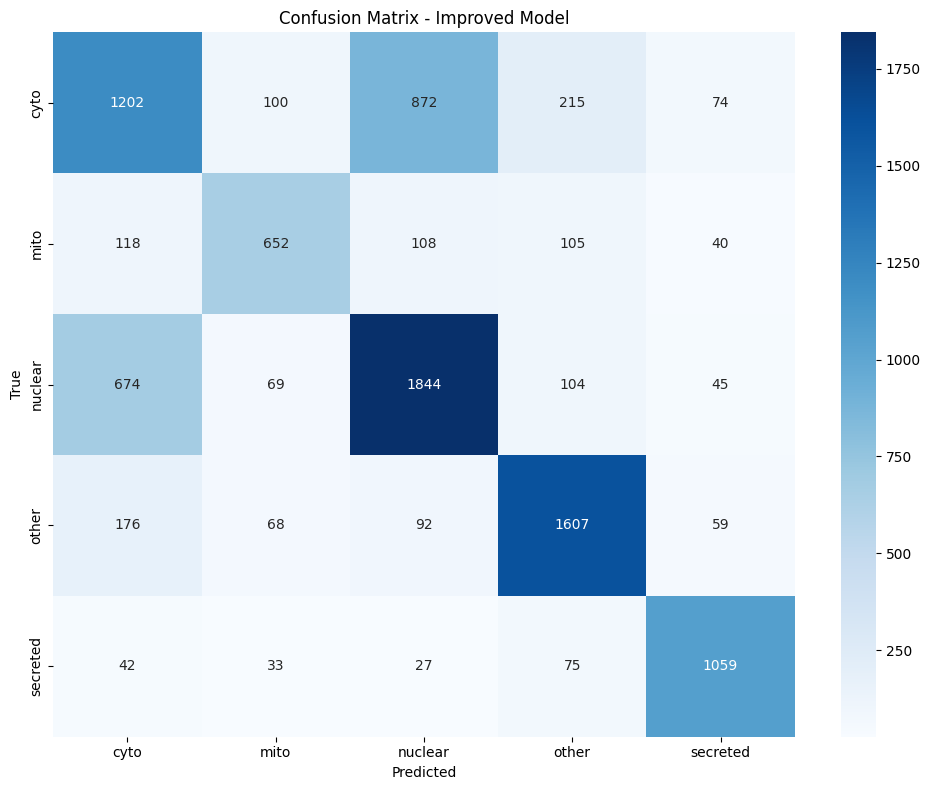

Training final model...

Blind Test Set Predictions:
SEQ01 Nucl Confidence Low
SEQ02 Othr Confidence Low
SEQ03 Mito Confidence Medium
SEQ04 Nucl Confidence Medium
SEQ05 Cyto Confidence Low
SEQ06 Mito Confidence Low
SEQ07 Extr Confidence Medium
SEQ08 Mito Confidence Low
SEQ09 Cyto Confidence Low
SEQ10 Extr Confidence Medium
SEQ11 Nucl Confidence Low
SEQ12 Nucl Confidence Low
SEQ13 Nucl Confidence Medium
SEQ14 Nucl Confidence Medium
SEQ15 Othr Confidence Medium
SEQ16 Nucl Confidence Medium
SEQ17 Cyto Confidence Low
SEQ18 Nucl Confidence Medium
SEQ19 Nucl Confidence Low
SEQ20 Othr Confidence Medium

Blind predictions saved to 'blind_predictions_improved.txt'


In [14]:
# Define amino acids and properties
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Properties of amino acids
aa_properties = {
    'positive': ['K', 'R', 'H'],
    'negative': ['D', 'E'],
    'hydrophobic': ['I', 'V', 'L', 'F', 'C', 'M', 'A', 'W']
}

# Kyte-Doolittle hydrophobicity scale
kd_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

def calculate_hydrophobicity(sequence, scale=kd_scale):
    """Calculate average hydrophobicity of a sequence"""
    if not sequence:
        return 0
    return sum(scale.get(aa, 0) for aa in sequence) / len(sequence)

def extract_enhanced_features(sequences_df):
    """Extract enhanced features for protein localization prediction"""
    features_list = []

    for idx, row in sequences_df.iterrows():
        seq_id = row['id']
        sequence = row['sequence']
        label = row.get('label', None)

        feature_dict = {'id': seq_id}

        # 1. Global amino acid composition (length feature removed)
        aa_count = Counter(sequence)
        for aa in amino_acids:
            feature_dict[f'global_{aa}'] = aa_count.get(aa, 0) / len(sequence) * 100 if len(sequence) > 0 else 0

        # 2. N-terminal and C-terminal composition
        n_term = sequence[:min(50, len(sequence))]
        c_term = sequence[max(0, len(sequence)-50):]

        n_term_count = Counter(n_term)
        c_term_count = Counter(c_term)

        for aa in amino_acids:
            feature_dict[f'nterm_{aa}'] = n_term_count.get(aa, 0) / len(n_term) * 100 if len(n_term) > 0 else 0
            feature_dict[f'cterm_{aa}'] = c_term_count.get(aa, 0) / len(c_term) * 100 if len(c_term) > 0 else 0

        # 3. Basic protein properties (molecular_weight removed)
        try:
            standard_seq = ''.join(aa for aa in sequence if aa in amino_acids)
            if standard_seq:
                protein_analysis = ProteinAnalysis(standard_seq)
                feature_dict['isoelectric_point'] = protein_analysis.isoelectric_point()
                feature_dict['gravy'] = protein_analysis.gravy()  # Hydropathy
            else:
                feature_dict['isoelectric_point'] = 7.0
                feature_dict['gravy'] = 0.0
        except Exception:
            feature_dict['isoelectric_point'] = 7.0
            feature_dict['gravy'] = 0.0

        # 4. Global charge features
        pos_aas = aa_properties['positive']
        neg_aas = aa_properties['negative']

        pos_count = sum(aa_count.get(aa, 0) for aa in pos_aas)
        neg_count = sum(aa_count.get(aa, 0) for aa in neg_aas)

        feature_dict['pos_charge_ratio'] = pos_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['neg_charge_ratio'] = neg_count / len(sequence) if len(sequence) > 0 else 0
        feature_dict['net_charge_ratio'] = (pos_count - neg_count) / len(sequence) if len(sequence) > 0 else 0

        # 5. N-terminal features
        n_term_20 = sequence[:min(20, len(sequence))]
        n_term_30 = sequence[:min(30, len(sequence))]

        # Calculate charges in different regions of the protein
        for term, suffix in [(n_term_20, '20'), (n_term_30, '30')]:
            term_count = Counter(term)
            term_pos = sum(term_count.get(aa, 0) for aa in pos_aas)
            term_neg = sum(term_count.get(aa, 0) for aa in neg_aas)
            term_len = len(term)

            if term_len > 0:
                feature_dict[f'nterm{suffix}_pos_charge'] = term_pos / term_len
                feature_dict[f'nterm{suffix}_neg_charge'] = term_neg / term_len
                feature_dict[f'nterm{suffix}_net_charge'] = (term_pos - term_neg) / term_len
                feature_dict[f'nterm{suffix}_hydrophobicity'] = calculate_hydrophobicity(term)
            else:
                feature_dict[f'nterm{suffix}_pos_charge'] = 0
                feature_dict[f'nterm{suffix}_neg_charge'] = 0
                feature_dict[f'nterm{suffix}_net_charge'] = 0
                feature_dict[f'nterm{suffix}_hydrophobicity'] = 0

        # 6. Nuclear localization signal detection
        has_nls = False
        for i in range(len(sequence) - 5):
            window = sequence[i:i+6]
            k_count = window.count('K')
            r_count = window.count('R')
            if (k_count + r_count) >= 4:  # 4+ basic residues in 6aa window
                has_nls = True
                break

        feature_dict['potential_nls'] = 1 if has_nls else 0

        # 7. Mitochondrial targeting sequence features
        if len(n_term_30) >= 15:
            mts_region = n_term_30[:15]
            mts_pos_count = sum(1 for aa in mts_region if aa in pos_aas)
            mts_hydro_count = sum(1 for aa in mts_region if aa in aa_properties['hydrophobic'])

            feature_dict['mts_pos_charge'] = mts_pos_count / len(mts_region)
            feature_dict['mts_hydrophobic'] = mts_hydro_count / len(mts_region)
            feature_dict['mts_score'] = feature_dict['mts_pos_charge'] * 0.6 + feature_dict['mts_hydrophobic'] * 0.4
        else:
            feature_dict['mts_pos_charge'] = 0
            feature_dict['mts_hydrophobic'] = 0
            feature_dict['mts_score'] = 0

        # 8. Signal peptide detection for secreted proteins
        if len(n_term_30) >= 15:
            # n-region (positive), h-region (hydrophobic)
            n_region = n_term_30[:5]
            h_region = n_term_30[5:15]

            n_region_pos = sum(1 for aa in n_region if aa in pos_aas) / len(n_region) if n_region else 0
            h_region_hydro = calculate_hydrophobicity(h_region)

            # Signal peptide score combines n-region charge and h-region hydrophobicity
            feature_dict['sp_score'] = (n_region_pos * 0.3 + (h_region_hydro/5 + 0.8) * 0.7)
        else:
            feature_dict['sp_score'] = 0

        # Add label if available
        if label is not None:
            feature_dict['label'] = label

        features_list.append(feature_dict)

    return pd.DataFrame(features_list)

# Extract enhanced features
print("Extracting enhanced features...")
enhanced_train_features = extract_enhanced_features(train_data)
enhanced_blind_features = extract_enhanced_features(data['blind'])

# Check for NaN values
enhanced_train_features = enhanced_train_features.fillna(0)
enhanced_blind_features = enhanced_blind_features.fillna(0)

# Prepare data
X_enhanced = enhanced_train_features.drop(['id', 'label'], axis=1)
y_enhanced = enhanced_train_features['label']

# Create pipeline with enhanced Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

# Manual cross-validation to get predictions
print("Performing cross-validation with enhanced features...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = np.zeros_like(y_enhanced, dtype=object)
y_proba = np.zeros((len(y_enhanced), len(np.unique(y_enhanced))))

for train_idx, test_idx in cv.split(X_enhanced, y_enhanced):
    X_train, X_test = X_enhanced.iloc[train_idx], X_enhanced.iloc[test_idx]
    y_train, y_test = y_enhanced.iloc[train_idx], y_enhanced.iloc[test_idx]

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred[test_idx] = pipeline.predict(X_test)

    # Get class indices
    classes = pipeline.classes_
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Store probabilities
    proba = pipeline.predict_proba(X_test)
    for i, idx in enumerate(test_idx):
        for cls in classes:
            cls_idx = class_indices[cls]
            if y_proba[idx, cls_idx] == 0:  # Only update if not set
                y_proba[idx, cls_idx] = proba[i, cls_idx]

# Print results
print("\nImproved Model Cross-Validation Results:")
print(classification_report(y_enhanced, y_pred))

# Calculate Matthews Correlation Coefficient
mcc_improved = matthews_corrcoef(y_enhanced, y_pred)
print(f"Matthews Correlation Coefficient: {mcc_improved:.4f}")

# Add comparison to original model
original_mcc = 0.5296  # Based on the provided value
print(f"Original MCC: {original_mcc:.4f}, Improved MCC: {mcc_improved:.4f}")
print(f"Improvement: {(mcc_improved - original_mcc) * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_enhanced, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=np.unique(y_enhanced),
           yticklabels=np.unique(y_enhanced))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Improved Model')
plt.tight_layout()
plt.show()

# Fit final model on all data
print("Training final model...")
pipeline.fit(X_enhanced, y_enhanced)

# Prepare blind test features
X_blind_enhanced = enhanced_blind_features.drop(['id'], axis=1)

# Ensure columns match
X_blind_final = pd.DataFrame(0, index=X_blind_enhanced.index, columns=X_enhanced.columns)
for col in X_blind_enhanced.columns:
    if col in X_enhanced.columns:
        X_blind_final[col] = X_blind_enhanced[col]

# Predict on blind test set
blind_pred = pipeline.predict(X_blind_final)
blind_proba = pipeline.predict_proba(X_blind_final)

# Define confidence levels
def get_confidence_level(probability):
    if probability >= 0.8:
        return "High"
    elif probability >= 0.5:
        return "Medium"
    else:
        return "Low"

# Format blind test predictions
print("\nBlind Test Set Predictions:")
blind_predictions = []

for i, seq_id in enumerate(enhanced_blind_features['id']):
    predicted_class = blind_pred[i]
    max_prob = np.max(blind_proba[i])
    confidence = get_confidence_level(max_prob)

    class_map = {
        'cyto': 'Cyto',
        'nuclear': 'Nucl',
        'mito': 'Mito',
        'secreted': 'Extr',
        'other': 'Othr'
    }

    formatted_class = class_map.get(predicted_class, predicted_class)
    result_line = f"{seq_id} {formatted_class} Confidence {confidence}"
    blind_predictions.append(result_line)
    print(result_line)

# Save predictions to file
with open('blind_predictions_improved.txt', 'w') as f:
    for line in blind_predictions:
        f.write(line + '\n')

print("\nBlind predictions saved to 'blind_predictions_improved.txt'")